In [1]:
import os

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import calendar

import datetime
plt.style.use('ggplot')

# Modeling concentration of PM2.5 across counties in California

__[Particulate matter (PM)](https://www.epa.gov/pm-pollution/particulate-matter-pm-basics)__ refers to tiny particles of solid or liquid suspended in the air. Particles with a diameter of 2.5 micrometers or smaller (PM2.5) are __[particularly concerning](https://ww2.arb.ca.gov/resources/inhalable-particulate-matter-and-health)__ because they can reach deep into the lungs and even the bloodstream. Exposure to PM2.5 has been linked to stroke, cardiovascular and respiratory disease, cancer, and other serious health outcomes. 

While daily concentrations above 35 μg/m³ are considered extremely hazardous, there is no known safe level of PM2.5 exposure.

PM2.5 comes from a wide range of sources, either emitted directly from vehicles, industrial activity, or fires, or formed in the atmosphere through chemical reactions involving pollutants like sulfur dioxide or nitrogen oxides. In California, wildfires are a major source. Ash and smoke contain __[high levels of PM2.5](https://www.epa.gov/wildfire-smoke-course/why-wildfire-smoke-health-concern)__, and wildfire events have become more frequent and intense with climate change.

In this notebook, we’ll build Bayesian hierarchical models to predict average monthly PM2.5 concentrations at the county level in California. We will use publicly available data provided by the U.S. __[Environmental Protection Agency (EPA)](https://www.epa.gov/outdoor-air-quality-data/download-daily-data)__. Our goal is to account for spatial and temporal variation and eventually quantify uncertainty in these predictions.


### Load data

In [2]:
folder_path = '/Users/oliverastojanovic/Desktop/PSIML_2025/data/'   # change this to your folder path
dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True).sort_values(by='Date')

## Exploratory data analysis

First, we’ll do a few quick checks: are there missing values, any NaNs, anything that looks unsual. If some data is missing, we’ll have to decide whether to drop or impute. We’ll also look at the distributions of the main variables because we need that to pick a reasonable likelihood for the Bayesian model.

In [3]:
data.head()

Date Source   Site ID  POC  Daily Mean PM2.5 Concentration  \
329990  01/01/2019    AQS  60690002    3                             2.3   
296724  01/01/2019    AQS  60010015    3                             2.7   
297076  01/01/2019    AQS  60070008    1                            13.5   
297237  01/01/2019    AQS  60070008    3                            12.5   
297970  01/01/2019    AQS  60074001    3                             5.4   

           Units  Daily AQI Value            Local Site Name  Daily Obs Count  \
329990  ug/m3 LC               13                  Hollister                1   
296724  ug/m3 LC               15      Pleasanton - Owens Ct                1   
297076  ug/m3 LC               59          Chico-East Avenue                1   
297237  ug/m3 LC               57          Chico-East Avenue                1   
297970  ug/m3 LC               30  TRAFFIC, RURAL PAVED ROAD                1   

        Percent Complete  ...  Method Code  \
329990             100.0  ...        170.0   
296724             100.0  ...        170.0   
297076             100.0  ...        145.0   
297237             100.0  ...        731.0   
297970             100.0  ...        731.0   

                                       Method Description  CBSA Code  \
329990               Met One BAM-1020 Mass Monitor w/VSCC    41940.0   
296724               Met One BAM-1020 Mass Monitor w/VSCC    41860.0   
297076  R & P Model 2025 PM-2.5 Sequential Air Sampler...    17020.0   
297237                       Met-One BAM-1020 W/PM2.5 SCC    17020.0   
297970                       Met-One BAM-1020 W/PM2.5 SCC    17020.0   

                                 CBSA Name  State FIPS Code       State  \
329990  San Jose-Sunnyvale-Santa Clara, CA                6  California   
296724   San Francisco-Oakland-Hayward, CA                6  California   
297076                           Chico, CA                6  California   
297237                           Chico, CA                6  California   
297970                           Chico, CA                6  California   

        County FIPS Code      County  Site Latitude Site Longitude  
329990                69  San Benito      36.843425    -121.362100  
296724                 1     Alameda      37.701222    -121.903019  
297076                 7       Butte      39.761680    -121.840470  
297237                 7       Butte      39.761680    -121.840470  
297970                 7       Butte      39.327563    -121.668811  

[5 rows x 22 columns]

In [4]:
data.describe()

Site ID            POC  Daily Mean PM2.5 Concentration  \
count  3.777970e+05  377797.000000                   377797.000000   
mean   6.056779e+07       3.293610                        9.025533   
std    2.945780e+05       3.887029                       11.977866   
min    6.001001e+07       1.000000                       -6.700000   
25%    6.031000e+07       1.000000                        4.100000   
50%    6.063101e+07       3.000000                        6.900000   
75%    6.075000e+07       3.000000                       10.800000   
max    6.113100e+07      26.000000                      824.100000   

       Daily AQI Value  Daily Obs Count  Percent Complete  AQS Parameter Code  \
count    377797.000000    377797.000000     377797.000000       377797.000000   
mean         40.347258         1.000222        100.022234        88192.692594   
std          26.455839         0.014909          1.490949          168.408057   
min           0.000000         1.000000        100.000000        88101.000000   
25%          23.000000         1.000000        100.000000        88101.000000   
50%          38.000000         1.000000        100.000000        88101.000000   
75%          54.000000         1.000000        100.000000        88101.000000   
max        1493.000000         2.000000        200.000000        88502.000000   

         Method Code      CBSA Code  State FIPS Code  County FIPS Code  \
count  357761.000000  346925.000000         377797.0     377797.000000   
mean      330.382196   35350.940232              6.0         56.634852   
std       250.379531    9865.278873              0.0         29.455437   
min       143.000000   12540.000000              6.0          1.000000   
25%       170.000000   31080.000000              6.0         31.000000   
50%       170.000000   40140.000000              6.0         63.000000   
75%       707.000000   41860.000000              6.0         75.000000   
max       810.000000   49700.000000              6.0        113.000000   

       Site Latitude  Site Longitude  
count  377797.000000   377797.000000  
mean       36.294985     -119.673694  
std         2.294345        2.016746  
min        32.552824     -124.203470  
25%        34.103740     -121.493110  
50%        36.489470     -119.706200  
75%        37.962069     -118.049167  
max        41.756130     -115.483070

It seems like we have some negative value in `Daily Mean PM2.5 Concentration` column, which shouldn't happen. Let's inspect those values.

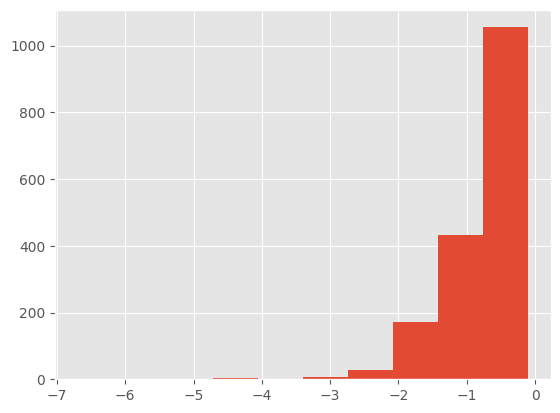

In [5]:
plt.hist(data[data["Daily Mean PM2.5 Concentration"]<0]["Daily Mean PM2.5 Concentration"])
plt.show()

Negative values usually come from equipment malfunction, and we will in this tutorial replace them with zeros.

In [6]:
data.loc[data["Daily Mean PM2.5 Concentration"] < 0, "Daily Mean PM2.5 Concentration"] = 0

In [7]:
data[data["Daily Mean PM2.5 Concentration"]<0]["Daily Mean PM2.5 Concentration"].sum() # the sum should we zero, we successfully replaced all negative values with zero

0.0

In [8]:
data.isnull().any() # there are some NaNs in the dataset, but we're lucky, we don't have any NaNs columns we will use

Date                              False
Source                            False
Site ID                           False
POC                               False
Daily Mean PM2.5 Concentration    False
Units                             False
Daily AQI Value                   False
Local Site Name                    True
Daily Obs Count                   False
Percent Complete                  False
AQS Parameter Code                False
AQS Parameter Description         False
Method Code                        True
Method Description                 True
CBSA Code                          True
CBSA Name                          True
State FIPS Code                   False
State                             False
County FIPS Code                  False
County                            False
Site Latitude                     False
Site Longitude                    False
dtype: bool

We want to fit a model on data from 2019 to 2024, and treat everything we have in 2025 as 'unseen data'. First, we need to ensure we have data for all counties during that period, as monitoring stations can sometimes go offline, be decommissioned, or fail to collect data for certain stretches of time.

In [9]:
# drop data for 2025
data['Date'] = pd.to_datetime(data['Date'])

rows_to_drop = data[data['Date'] > datetime.datetime(2024, 12, 31)].index

data = data.drop(rows_to_drop)

In [10]:
counties_list = data['County'].unique().tolist()

print("These counties have some data missing in the last 6 years:")

missing_counties = []
missing_dates_expanded = []
percentage_missing_list = [] 

# Define the expected date range for the last 6 years
start_date = "2019-01-01"
end_date = "2024-12-31"
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

for county in counties_list:
    county_data = data[data['County'] == county]
    
    # Ensure only unique dates are considered
    actual_dates = pd.to_datetime(county_data['Date']).drop_duplicates().sort_values()
    
    # Find missing dates by comparing expected and actual dates
    missing_dates = expected_dates.difference(actual_dates)
    
    if len(missing_dates) > 0: 
        missing_counties.append(county)
        percentage_missing = np.round((100 - len(actual_dates) / len(expected_dates) * 100), 2)
        percentage_missing_list.append({"County": county, "Percentage Missing": percentage_missing})
        
        for date in missing_dates:
            missing_dates_expanded.append({"County": county, "Missing Date": date})
        print(county, "has", percentage_missing, "% of data missing")

missing_dates_df = pd.DataFrame(missing_dates_expanded)
percentage_missing_df = pd.DataFrame(percentage_missing_list)
missing_dates_df = missing_dates_df.merge(percentage_missing_df, on="County", how="left")

These counties have some data missing in the last 6 years:
San Benito has 1.55 % of data missing
San Mateo has 5.34 % of data missing
Calaveras has 3.7 % of data missing
Colusa has 0.59 % of data missing
Contra Costa has 0.73 % of data missing
Glenn has 2.83 % of data missing
Imperial has 0.14 % of data missing
Yolo has 2.78 % of data missing
Ventura has 0.05 % of data missing
Tulare has 0.05 % of data missing
Tehama has 4.06 % of data missing
Sutter has 1.32 % of data missing
Sonoma has 8.62 % of data missing
Solano has 9.22 % of data missing
Siskiyou has 3.24 % of data missing
Santa Cruz has 0.09 % of data missing
Santa Clara has 0.18 % of data missing
Napa has 61.82 % of data missing
Orange has 0.5 % of data missing
San Francisco has 11.13 % of data missing
Mono has 4.97 % of data missing
Merced has 0.36 % of data missing
Mendocino has 0.32 % of data missing
Mariposa has 6.71 % of data missing
Marin has 1.55 % of data missing
Madera has 2.65 % of data missing
Del Norte has 16.83 % o

Most counties with missing dates have a very low percentage of missing data, which probably means there’s just an occasional missing date. In those cases, we can impute average values.

However, a few counties have a substantially higher proportion of missing dates, like Napa (61.82%) or Humboldt (53.6%). This likely indicates that monitoring stations went offline for an extended period. In such cases, it doesn’t make sense to impute average values. A common rule of thumb is that imputation is reasonable when less than 25% of the data is missing, although  this heavily depends on the context.

In our case, Shasta County has 25.55% missing data. That’s borderline, so we could reasonably go either way. I decided to keep it, since we're already excluding a few other counties.

In [11]:
counties_to_drop = percentage_missing_df[percentage_missing_df["Percentage Missing"] >= 26]["County"].tolist()

data = data[~data["County"].isin(counties_to_drop)].reset_index(drop=True)

remaining_counties = data["County"].unique()
print(f"Remaining counties: {len(remaining_counties)}")
print(f"Counties still in data: {remaining_counties}")

Remaining counties: 47
Counties still in data: ['San Benito' 'Alameda' 'Butte' 'San Mateo' 'Calaveras' 'Colusa'
 'San Luis Obispo' 'Contra Costa' 'Fresno' 'Glenn' 'Imperial' 'Inyo'
 'San Joaquin' 'Kern' 'Santa Barbara' 'San Bernardino' 'Yolo' 'Ventura'
 'Tulare' 'Tehama' 'Sutter' 'Stanislaus' 'Sonoma' 'Solano' 'Siskiyou'
 'Santa Cruz' 'Santa Clara' 'Kings' 'San Diego' 'Orange' 'Placer'
 'Riverside' 'Sacramento' 'Monterey' 'Los Angeles' 'San Francisco' 'Mono'
 'Merced' 'Mendocino' 'Mariposa' 'Marin' 'Madera' 'Del Norte' 'Trinity'
 'Nevada' 'Plumas' 'Shasta']


### Impute data

In [12]:
# Filter out counties to drop
missing_dates_df = missing_dates_df[~missing_dates_df['County'].isin(counties_to_drop)].reset_index(drop=True)

new_rows = []

for county in missing_dates_df['County'].unique():
    county_missing_dates = missing_dates_df[missing_dates_df['County'] == county]['Missing Date']
    
    # Get a sample row for the county to copy other column values
    sample_row = data[data['County'] == county].iloc[0].to_dict()
    
    # Calculate mean values for specific columns
    mean_values = data[data['County'] == county][['Daily Mean PM2.5 Concentration', 'Daily AQI Value', 'Daily Obs Count']].mean()

    # Create new rows for missing dates
    for missing_date in county_missing_dates:
        new_row = sample_row.copy() 
        new_row['Date'] = missing_date 
        new_row.update(mean_values.to_dict())
        new_rows.append(new_row)

data = pd.concat([data, pd.DataFrame(new_rows)], ignore_index=True)
data = data.sort_values(by=['County', 'Date']).reset_index(drop=True)

In [13]:
# Check if there are any missing dates in the entire data DataFrame
start_date = "2019-01-01"
end_date = "2024-12-31"
expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')

actual_dates = pd.to_datetime(data['Date']).drop_duplicates().sort_values()
missing_dates = expected_dates.difference(actual_dates)

if len(missing_dates) > 0:
    print(f"The dataset still has {len(missing_dates)} missing dates.")
else:
    print("The dataset has no missing dates.")

The dataset has no missing dates.


### Time-series of daily PM2.5 concentration

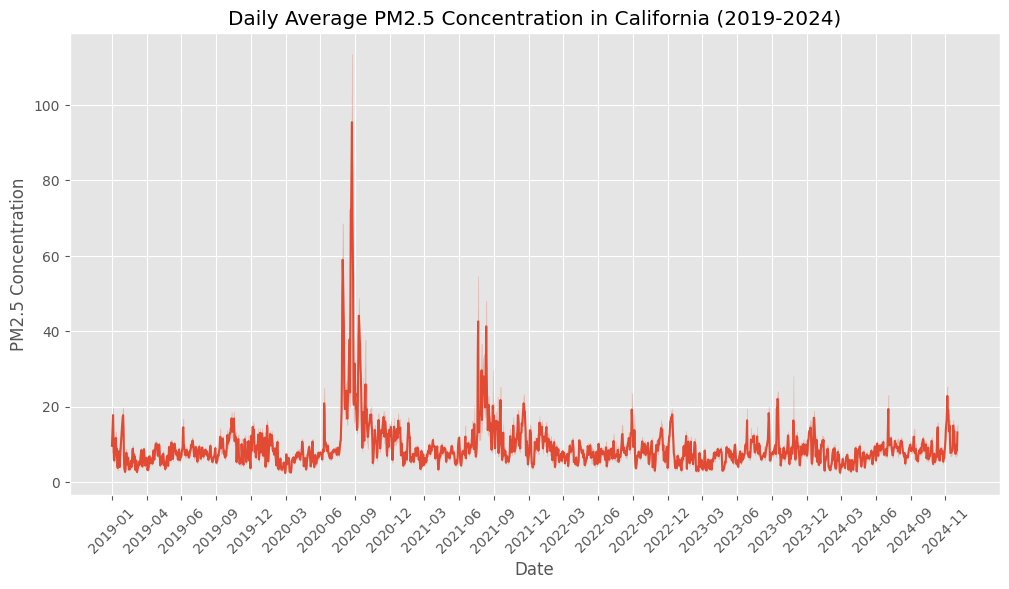

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x="Date", y="Daily Mean PM2.5 Concentration")

tick_step = 90 # put ticks every 3 months
unique_dates = pd.Series(data['Date'].unique()) 
plt.xticks(ticks=unique_dates[::tick_step], 
           labels=unique_dates[::tick_step].dt.strftime('%Y-%m'), 
           rotation=45)

plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.title("Daily Average PM2.5 Concentration in California (2019-2024)")
plt.show()

We see that on most days, daily concentration in California is around 20 μg/m³ or less. There are some big spikes in 2020 and 2021, which probably come from a big wildfire or similar extreme event.

### Does data have seasonality?

Before developing a model, we should check whether the data exhibits any seasonal patterns.

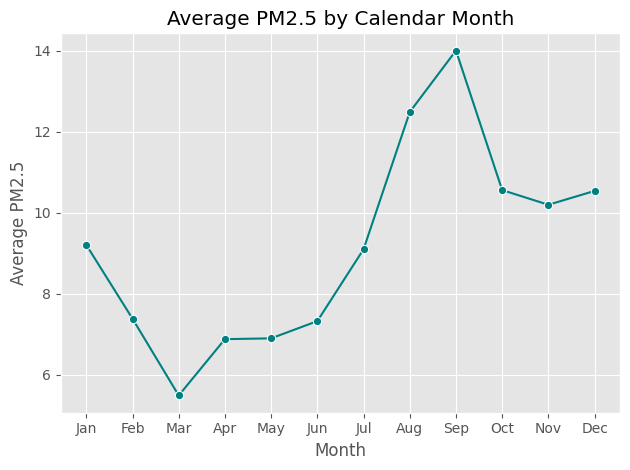

In [15]:
data["month_name"] = data["Date"].dt.strftime('%b')
data["month_num"] = data["Date"].dt.month  # for correct ordering

# Group by month number to preserve order
monthly_seasonal_avg = data.groupby("month_num")["Daily Mean PM2.5 Concentration"].mean().reset_index()

monthly_seasonal_avg["month_name"] = monthly_seasonal_avg["month_num"].apply(lambda x: calendar.month_abbr[x]) 

sns.lineplot(x='month_name', y='Daily Mean PM2.5 Concentration', data=monthly_seasonal_avg, marker='o', color='teal')
plt.title("Average PM2.5 by Calendar Month")
plt.xlabel("Month")
plt.ylabel("Average PM2.5")
plt.tight_layout()
plt.show()


We see higher average monthly concentration of PM2.5 in September and toward the end of the year and in January. 

This pattern likely reflects a combination of factors: 

* wildfire activity in late summer and fall, driven in part by strong dry winds such as the __[Santa Ana winds](https://en.wikipedia.org/wiki/Santa_Ana_winds)__ in Southern California and __[Diablo winds](https://en.wikipedia.org/wiki/Diablo_wind)__ in Northern California, which rapidly spread fires and worsen air quality

* winter pollution events like __[temperature inversions](https://www.eea.europa.eu/en/analysis/maps-and-charts/temperature-inversion-traps-pollution-at)__ and residential heating contribute to elevated PM2.5 levels in the colder months.

## Calculate monthly average

We have daily data, but for the rest of the tutorial we’ll use monthly averages. Using monthly data reduces computational load and helps the model run faster. It also smooths out short-term fluctuations, which makes it easier to focus on longer-term trends.

We will now calculate monthly average concentration of PM2.5 and some variables that will help us incorproate seasonality into our model later.

In [16]:
# Sort the DataFrame by 'county' and 'year_month'and extract the first date for each county
# We know that first date everywhere should be 2019-01-01, 
# but let's do it automatically just in case one county has no data for that month 
data = data.sort_values(by=['County', 'Date'])

first_dates = data.groupby('County')['Date'].first().reset_index()
first_dates.rename(columns={'Date': 'first_date'}, inplace=True)  # Rename the column to 'first_date'

data = data.merge(first_dates, on='County', how='left')

In [17]:
# compute the total time since beginning of time-serials (in years)
# This will be later used to calculate seasonality and trend

data["time_passed_total"] = (
    data['Date'].apply(datetime.datetime.toordinal)
    -data['first_date'].apply(datetime.datetime.toordinal)
)/365.0

In [18]:
data_copy = data.copy()

data_copy['year_month'] = data_copy['Date'].dt.strftime('%Y-%m')

monthly_avg = data_copy.groupby(['County', 'year_month'])['Daily Mean PM2.5 Concentration'].mean().reset_index()

monthly_avg.rename(columns={'Daily Mean PM2.5 Concentration': 'Monthly Avg PM2.5'}, inplace=True)

first_dates = monthly_avg.groupby('County')['year_month'].first().reset_index()
first_dates.rename(columns={'year_month': 'first_date'}, inplace=True)

monthly_avg = monthly_avg.merge(first_dates, on='County', how='left')

monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'], format='%Y-%m')
monthly_avg['first_date'] = pd.to_datetime(monthly_avg['first_date'], format='%Y-%m')

# Calculate time passed in years since county's first month (for trend)
monthly_avg["time_passed_total"] = (
    monthly_avg['year_month'].apply(datetime.datetime.toordinal)
    - monthly_avg['first_date'].apply(datetime.datetime.toordinal)
) / 365.0


monthly_avg['month'] = monthly_avg['year_month'].dt.month

# Normalize month to [0,1) for seasonality
monthly_avg['month_fraction'] = (monthly_avg['month'] - 1) / 12.0

monthly_avg['county_id'] = monthly_avg['County'].astype('category').cat.codes
n_counties = monthly_avg['county_id'].nunique()

In [19]:
# this is how our new dataframe looks like
monthly_avg.head()

County year_month  Monthly Avg PM2.5 first_date  time_passed_total  month  \
0  Alameda 2019-01-01           9.066667 2019-01-01           0.000000      1   
1  Alameda 2019-02-01           4.255952 2019-01-01           0.084932      2   
2  Alameda 2019-03-01           5.255978 2019-01-01           0.161644      3   
3  Alameda 2019-04-01           7.265294 2019-01-01           0.246575      4   
4  Alameda 2019-05-01           6.307065 2019-01-01           0.328767      5   

   month_fraction  county_id  
0        0.000000          0  
1        0.083333          0  
2        0.166667          0  
3        0.250000          0  
4        0.333333          0

### Plot distribution of monthly average

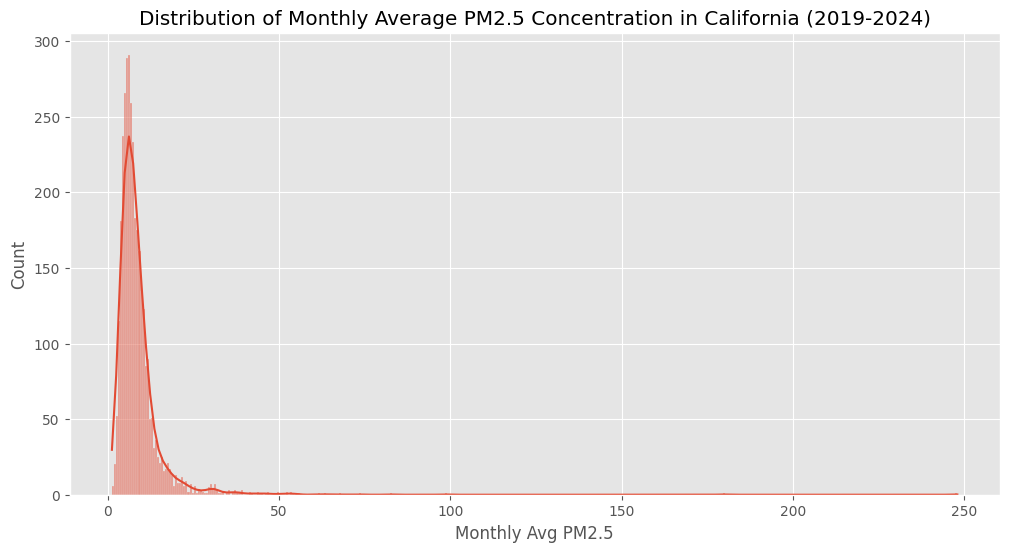

In [20]:
plt.figure(figsize=(12, 6))

sns.histplot(monthly_avg["Monthly Avg PM2.5"], kde=True)

plt.title("Distribution of Monthly Average PM2.5 Concentration in California (2019-2024)")
plt.show()

As expected, many data points are between 0 and 20. There's also a small bump between 20 and 50, and a long tail. Let's plot a distribution for a couple of counties to get a better sense of data.

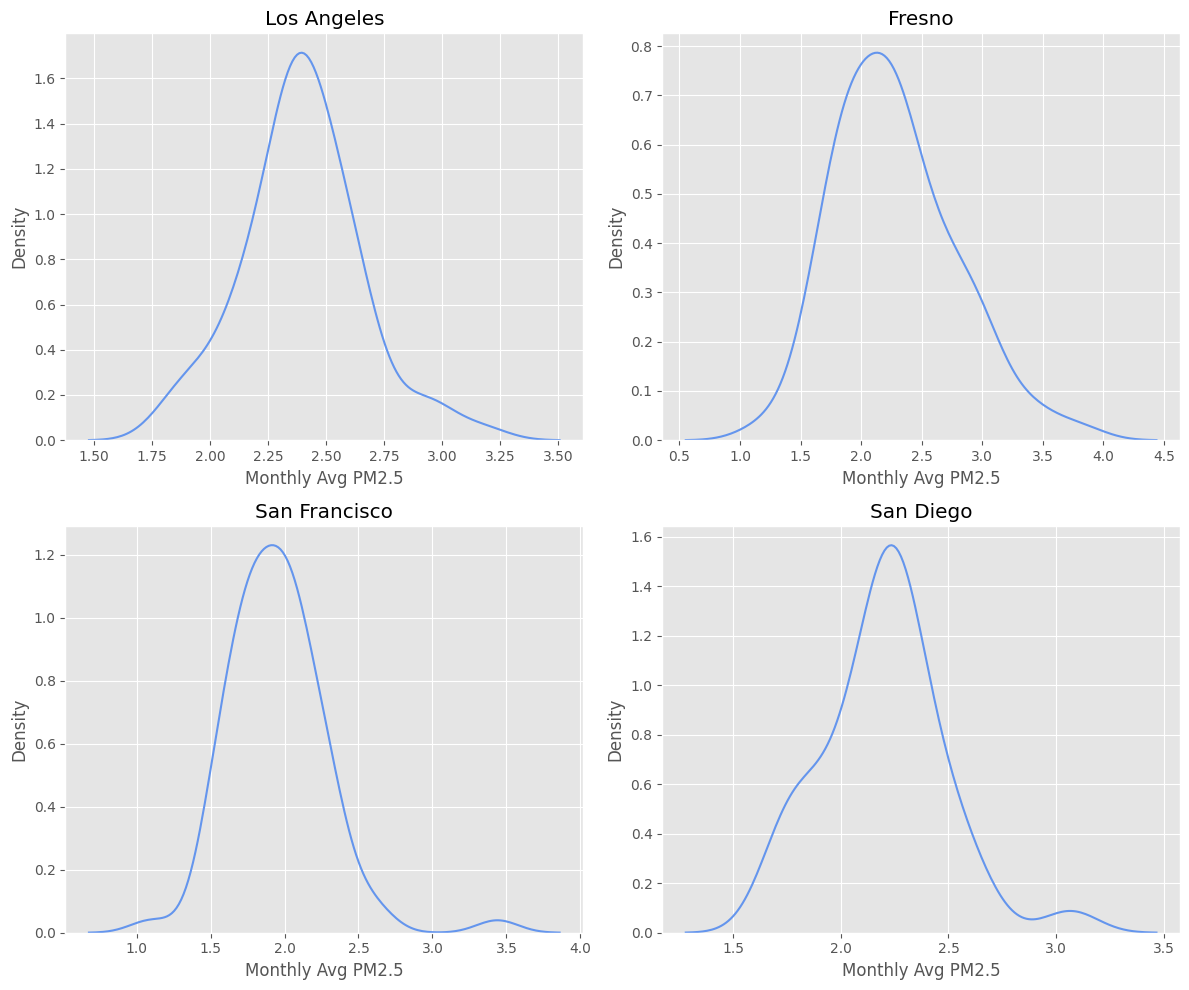

In [21]:
counties = ['Los Angeles', 'Fresno', 'San Francisco', 'San Diego']


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, county in zip(axes.flatten(), counties):
    county_data = monthly_avg[monthly_avg['County'] == county]
    sns.kdeplot(np.log(county_data['Monthly Avg PM2.5']), color='cornflowerblue', ax=ax)
    ax.set_title(county)
    ax.set_xlabel('Monthly Avg PM2.5')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

Looking at these distributions, it’s clear the data doesn’t follow a Normal distribution. It looks like it might be bimodal. It's probably a mix of two distributions, which would make sense. On most days PM2.5 is low, but during wildfires it can get very high.

It seems like on "good days" data follows a __[LogNormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)__ (no negative values), but bad days it probably follows a different LogNormal with a higher mean. That pattern suggests there might be some kind of threshold or shift when extreme events occur.

We will now use this information to fit a Bayesian model.

## Fitting a Bayesian hierarchical model

### Bayesian hierarchical models

__[Bayesian hierarchical models](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling)__ are a class of statistical models that involve multiple levels of parameters, allowing for the modeling of complex, structured data. They are particularly useful when data is organized in groups or layers, such as nested or repeated measurements, or when modeling different regions that share common characteristics. In these models, parameters at one level of the hierarchy depend on parameters at a higher level, facilitating the sharing of information across different groups. This approach leads to more accurate and robust inferences, especially when some groups, have limited data.

### Fitting a model in PyMC

We will build our models using __[PyMC](https://www.pymc.io/projects/docs/en/stable/learn.html)__, a python package for Bayesian inference. 

We’ll use PyMC, a Python library for building Bayesian models and running inference with MCMC. It’s useful when you want to define probabilistic models explicitly, use priors, and get full posterior distributions instead of point estimates. PyMC lets you write models in code that closely mirrors their mathematical structure, and it supports advanced features like hierarchical models, custom likelihoods, and missing data handling.

If you're starting with PyMC, I suggest reading about __[its core features](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/index.html)__ , the __[Introductiory Overview of PyMC](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)__ or how to fit a __[GLM regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)__ in PyMC.


In PyMC, models are defined inside a `pm.Model()` context manager. All components (priors, likelihoods, transformations, and observed data) must be declared within this block so PyMC can track them and handle inference properly.

Within the model context, we will define:

* **Priors** - distributions that reflect our assumptions before seeing the data,

* **The expected value and standard deviation** of the likelihood, and

* **The likelihood function** itself, which links parameters to the observed data.

To fit the model, we will use __[Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)__. Directly computing the posterior distribution is infeasible for most real-world models, so we approximate it using MCMC. This generates a sequence of samples (called *draws*) from the posterior distribution, which we can then use to estimate parameter values, uncertainty intervals, or make predictions.

Each **draw** is one sample from the posterior, and represents **one possible combination of values for all the model’s parameters at once**. This means that for every parameter in the model (e.g., intercepts, slopes, variances, or group-level effects), you get one specific value in that draw. 

So, when PyMC reports that "*50 draws are finished*" it means the sampler has generated 50 such samples and each contains values for all parameters. These 50 draws together represent 50 different possible sets of parameter values drawn from the posterior distribution.

A **chain** is an independent sequence of such draws. Running multiple chains (e.g. `chains=4`) helps us check whether sampling has converged (i.e., whether different chains explore the same distribution).

The output of `pm.sample()` is called a **trace**. It contains all the MCMC draws across all chains and parameters.

You can think of the trace as a structured container (like a multidimensional array or cube), which stores all sampled combinations of model parameters. In hierarchical models, it represents an entire posterior predictive distribution for each group or time series.

## Model 1: No hierarchy

To start, we’ll fit a non-hierarchical model. This simpler version will make it easier to explore PyMC’s features and be our a sanity check when we compare it to more complex models.

In this model, we include seasonality because the data clearly shows a strong seasonal pattern. We also define an intercept to capture the baseline level.

Since most days in our data don’t contain extreme values but occasional extreme events do occur, we model the probability of extremes using a __[Bernoulli distribution](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Bernoulli.html)__. Depending on whether an extreme event occurs, the model switches between two __[LogNormal](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.LogNormal.html)__ likelihoods, one for typical days and one for extreme days.

In [22]:
with pm.Model() as model_no_hierarchy:

    # --- Priors for seasonality ---
    # We model seasonal effects using sine and cosine terms to capture cyclical patterns over months.
    # The month_fraction variable represents the time within a year as a fraction (e.g., 0.0 to 1.0).
    # Taking sine and cosine of 2π * month_fraction captures annual seasonality.
    
    sine = pm.math.sin(2 * np.pi * (monthly_avg["month_fraction"].values % 1))
    cosine = pm.math.cos(2 * np.pi * (monthly_avg["month_fraction"].values % 1))

    # We assign Normal priors to the coefficients of the sine and cosine terms,
    # reflecting uncertainty about the amplitude of seasonal effects.
    w_s = pm.Normal("w_s", mu=0, sigma=1)
    w_c = pm.Normal("w_c", mu=0, sigma=1)

    # The overall seasonal effect is a linear combination of sine and cosine terms weighted by w_s and w_c.
    seasonality = sine * w_s + cosine * w_c

    # --- Priors for intercept ---
    # The intercept represents the baseline log-level of PM2.5 without seasonality or extremes.
    # We define a with a wide prior for the mean intercept (intercept_mu)
    # and a narrower offset term (intercept_offset) to allow some flexibility.

    intercept_mu = pm.Normal("intercept_mu", mu=0, sigma=5)  # wide prior on mean
    intercept_offset = pm.Normal("intercept_offset", mu=0, sigma=1)

    intercept = intercept_mu + intercept_offset

    # --- Modeling extreme events ---
    # We create a binary indicator variable 'is_extreme' to capture days with unusually high PM2.5.
    # The probability of an extreme event is modeled with a Beta prior to allow it to be low but flexible.
    
    p_is_extreme = pm.Beta("p_is_extreme", alpha=1, beta=20)
    is_extreme = pm.Bernoulli("is_extreme", p_is_extreme, shape=monthly_avg.shape[0])  

    # --- Expected value of PM2.5 ---
    # The baseline expected log PM2.5 is the sum of intercept and seasonal effect (mu_base).
   
    mu_base = intercept + seasonality

    # For extreme events, we allow a separate, higher mean value (mu_extreme) with a fairly wide prior.
    mu_extreme = pm.Normal("mu_extreme", mu=5, sigma=5)

    # We switch between baseline and extreme expected values depending on 'is_extreme'.
    mu = pm.math.switch(is_extreme, mu_extreme, mu_base)

    # --- Priors for standard deviations ---
    # We model measurement noise or natural variability with two HalfNormal priors:
    # one for the baseline condition (sigma_base), and one for extreme events (sigma_extreme).

    sigma_base = pm.HalfNormal("sigma_base", sigma=1)
    sigma_extreme = pm.HalfNormal("sigma_extreme", sigma=1)

    # We switch the standard deviation based on 'is_extreme' status.

    sigma = pm.math.switch(is_extreme, sigma_extreme, sigma_base)

    # --- Likelihood ---
    # The observed PM2.5 values are modeled as LogNormal distributed,
    # since PM2.5 concentrations are positive and often right-skewed.
    # The LogNormal distribution uses the 'mu' and 'sigma' defined above.
  
    Y = pm.LogNormal("Y", 
                    mu=mu, 
                    sigma=sigma, 
                    observed=monthly_avg['Monthly Avg PM2.5'])
    
    # --- Sampling ---
    # We draw 1000 posterior samples per chain after 500 tuning steps,
    # using 4 independent chains run in parallel on 4 CPU cores.

    trace_no_hierarchy = pm.sample(1000, tune=500, chains=4, cores=4, return_inferencedata=True)

    # --- Compute log likelihood ---
    # This is useful for model comparison or further diagnostics.
    pm.compute_log_likelihood(trace_no_hierarchy)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w_s, w_c, intercept_mu, intercept_offset, p_is_extreme, mu_extreme, sigma_base, sigma_extreme]
>BinaryGibbsMetropolis: [is_extreme]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 491 seconds.
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

### Inspect trace object and visualize the model

In [23]:
trace_no_hierarchy

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [24]:
# Let's look at the posterior samples directly
trace_no_hierarchy.posterior

<xarray.Dataset> Size: 109MB
Dimensions:           (chain: 4, draw: 1000, is_extreme_dim_0: 3384)
Coordinates:
  * chain             (chain) int64 32B 0 1 2 3
  * draw              (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * is_extreme_dim_0  (is_extreme_dim_0) int64 27kB 0 1 2 3 ... 3381 3382 3383
Data variables:
    w_s               (chain, draw) float64 32kB -0.2627 -0.2576 ... -0.2598
    w_c               (chain, draw) float64 32kB 0.01373 0.006552 ... 0.004105
    intercept_mu      (chain, draw) float64 32kB 2.271 2.937 ... 2.893 2.919
    intercept_offset  (chain, draw) float64 32kB -0.2977 -0.9788 ... -0.9567
    is_extreme        (chain, draw, is_extreme_dim_0) int64 108MB 0 0 0 ... 0 0
    mu_extreme        (chain, draw) float64 32kB 3.437 3.568 ... 3.334 3.315
    p_is_extreme      (chain, draw) float64 32kB 0.02508 0.02753 ... 0.03098
    sigma_base        (chain, draw) float64 32kB 0.4234 0.4272 ... 0.4222 0.4178
    sigma_extreme     (chain, draw) float64 32kB 0.5002 0.507 ... 0.5359 0.7119
Attributes:
    created_at:                 2025-08-01T21:52:17.975494+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.23.0
    sampling_time:              491.17145681381226
    tuning_steps:               500

In [25]:
# view the samples for 'intercept_mu'
trace_no_hierarchy.posterior["intercept_mu"]

<xarray.DataArray 'intercept_mu' (chain: 4, draw: 1000)> Size: 32kB
array([[2.27060146, 2.936874  , 3.12166085, ..., 2.30409878, 0.87159274,
        1.16210723],
       [1.30121852, 1.33434011, 1.32545696, ..., 3.45584961, 2.30045765,
        2.45282906],
       [2.52702864, 2.53119863, 1.81633732, ..., 2.35214357, 2.41379336,
        3.45922853],
       [1.42891923, 1.346221  , 1.41007821, ..., 3.04682472, 2.89328327,
        2.91930127]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [26]:
print("dimensions: ", trace_no_hierarchy.posterior["intercept_mu"].dims)
print("shape: ", trace_no_hierarchy.posterior["intercept_mu"].shape)

dimensions:  ('chain', 'draw')
shape:  (4, 1000)


In [27]:
# We can also print the model object to inspect its structure.
# This shows the model's components (priors, likelihoods, etc.) and how they are connected.
# It’s useful for verifying that everything is defined as expected.

model_no_hierarchy

             w_s ~ Normal(0, 1)
             w_c ~ Normal(0, 1)
    intercept_mu ~ Normal(0, 5)
intercept_offset ~ Normal(0, 1)
    p_is_extreme ~ Beta(1, 20)
      is_extreme ~ Bernoulli(p_is_extreme)
      mu_extreme ~ Normal(5, 5)
      sigma_base ~ HalfNormal(0, 1)
   sigma_extreme ~ HalfNormal(0, 1)
               Y ~ LogNormal(f(is_extreme, mu_extreme, intercept_offset, intercept_mu, w_c, w_s), f(is_extreme, sigma_extreme, sigma_base))

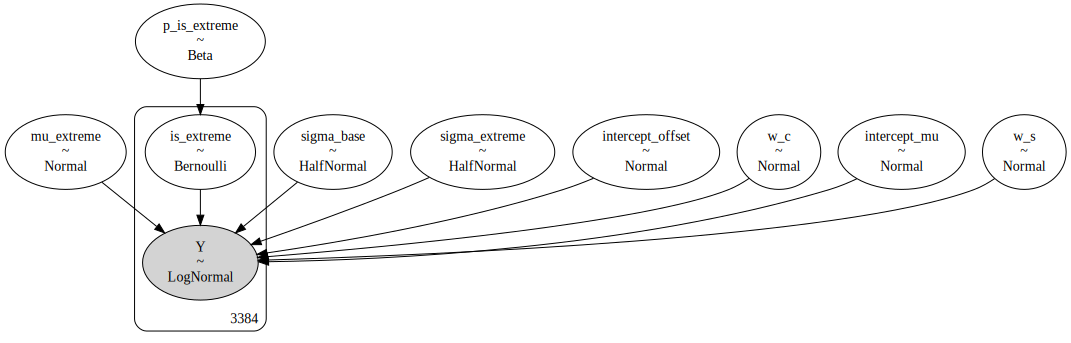

In [28]:
# We can also visualize the model structure using Graphviz.
# This generates a computational graph showing how all variables are connected in the model

pm.model_to_graphviz(model_no_hierarchy)

### Convergence checks

The R-hat statistic, also known as the __[Gelman-Rubin diagnostic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic)__, is used to assess the convergence of MCMC chains. It compares the variance within each chain to the variance between chains. If the chains have converged, the within-chain variance should be similar to the between-chain variance, and R-hat should be close to 1. An R-hat value significantly greater than 1.01 indicates that the chains have not yet converged, suggesting that more iterations may be needed to obtain reliable estimates from the MCMC sampling.

We will use `az.summary()` to get for an overview of the posterior distributions. 

For each parameter, the function shows:

* `mean`: the average of the posterior samples

* `sd`: standard deviation, showing uncertainty

* `hdi_3%` / `hdi_97%`: lower and upper bounds of the 94% highest density interval (by default), representing the range where most values fall

* `r_hat`: a convergence diagnostic (should be close to 1.0, or not higher than 1.01)

* `ess_bulk` / `ess_tail`: effective sample sizes, it measures how much independent information the samples contain

In [29]:
az.summary(trace_no_hierarchy,
           var_names=['w_s', 
                      'w_c', 
                      'intercept_mu', 
                      'intercept_offset', 
                      'mu_extreme', 
                      'sigma_base', 
                      'sigma_extreme', 
                      'p_is_extreme'])


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w_s              -0.259  0.011  -0.281   -0.239      0.000    0.000    1577.0   
w_c               0.015  0.011  -0.006    0.035      0.000    0.000    2024.0   
intercept_mu      1.881  0.984   0.140    3.840      0.026    0.018    1412.0   
intercept_offset  0.087  0.984  -1.855    1.839      0.026    0.018    1414.0   
mu_extreme        3.398  0.223   2.830    3.723      0.046    0.061      50.0   
sigma_base        0.420  0.007   0.406    0.433      0.001    0.000     136.0   
sigma_extreme     0.572  0.124   0.407    0.879      0.024    0.031      57.0   
p_is_extreme      0.031  0.010   0.017    0.051      0.002    0.003      51.0   

                  ess_tail  r_hat  
w_s                 1961.0   1.00  
w_c                 2201.0   1.00  
intercept_mu        1744.0   1.00  
intercept_offset    1721.0   1.00  
mu_extreme            27.0   1.06  
sigma_base           109.0   1.03  
sigma_extreme         27.0   1.05  
p_is_extreme          26.0   1.06

This looks good so far!

In [30]:
az.summary(trace_no_hierarchy,
           var_names=['is_extreme'])


/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
is_extreme[0]     0.004  0.065     0.0      0.0      0.002    0.012    1659.0   
is_extreme[1]     0.002  0.045     0.0      0.0      0.002    0.017     846.0   
is_extreme[2]     0.001  0.032     0.0      0.0      0.001    0.012    1609.0   
is_extreme[3]     0.004  0.059     0.0      0.0      0.001    0.010    2372.0   
is_extreme[4]     0.001  0.035     0.0      0.0      0.001    0.008    4024.0   
...                 ...    ...     ...      ...        ...      ...       ...   
is_extreme[3379]  0.003  0.052     0.0      0.0      0.001    0.010    2600.0   
is_extreme[3380]  0.003  0.052     0.0      0.0      0.001    0.011    2118.0   
is_extreme[3381]  0.003  0.052     0.0      0.0      0.001    0.009    2949.0   
is_extreme[3382]  0.004  0.059     0.0      0.0      0.001    0.008    3529.0   
is_extreme[3383]  0.021  0.143     0.0      0.0      0.003    0.009    2717.0   

                  ess_tail  r_hat  
is_extreme[0]       1659.0   1.00  
is_extreme[1]        846.0   1.01  
is_extreme[2]       1609.0   1.00  
is_extreme[3]       2372.0   1.00  
is_extreme[4]       4024.0   1.00  
...                    ...    ...  
is_extreme[3379]    2600.0   1.00  
is_extreme[3380]    2118.0   1.00  
is_extreme[3381]    2949.0   1.00  
is_extreme[3382]    3529.0   1.00  
is_extreme[3383]    2717.0   1.00  

[3384 rows x 9 columns]

However, here we start to see issues. Although our model correctly estimates that `is_extreme` is close to 0 for most observations, diagnostics like effective sample size or R-hat show problems. Because we sample `is_extreme` for each observation, we introduce a large number of discrete latent variables (one per data point). 

Issues happens because:

* Gradient-based samplers like NUTS struggle with discrete variables,

* Sampling thousands of binary latent variables individually can lead to inefficient exploration and stuck chains.

For now, we accept this limitation and continue analyzing the model since we still get reasonable estimates for is_extreme. Fixing these issues would require more advanced steps like marginalizing out the discrete variables or using samplers designed for discrete parameters (project ideas?).


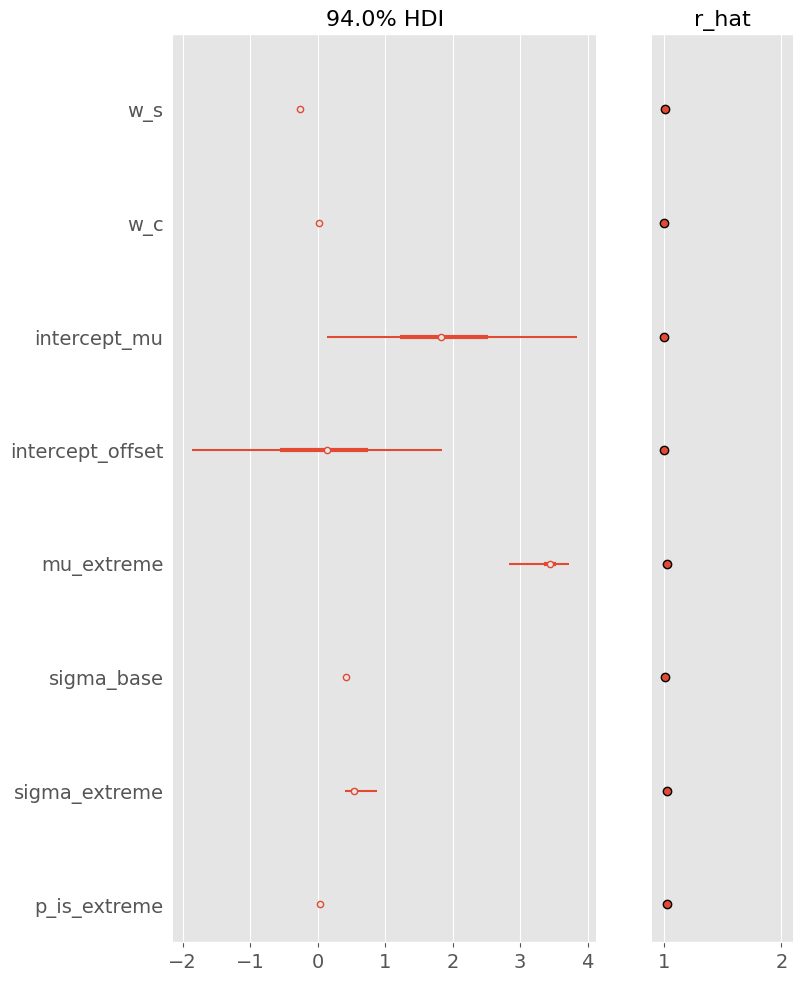

In [31]:
az.plot_forest(trace_no_hierarchy, 
               var_names=['w_s', 
                          'w_c', 
                          'intercept_mu', 
                          'intercept_offset', 
                          'mu_extreme', 
                          'sigma_base', 
                          'sigma_extreme', 
                          'p_is_extreme'], 
               combined=True, r_hat=True)
plt.show()

We have a forest plot showing the posterior distributions and 94% credible intervals of selected parameters, with R-hat values to assess convergence across chains.

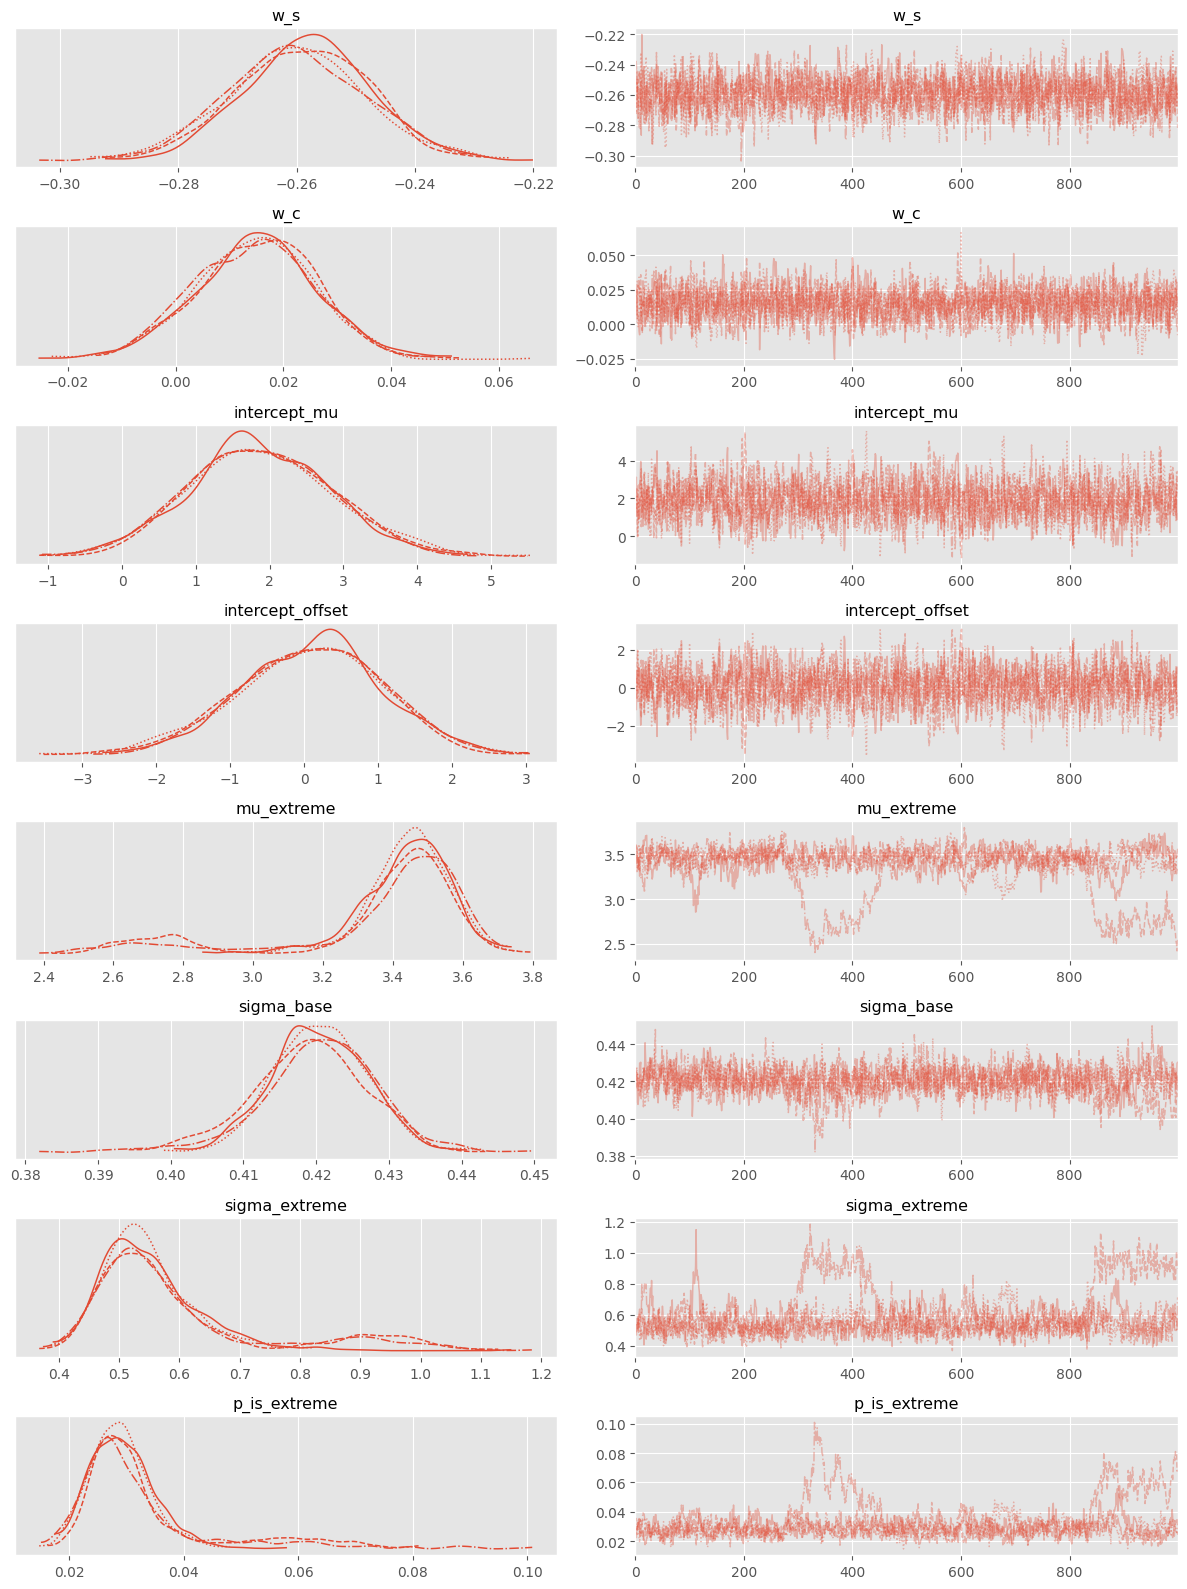

In [32]:
az.plot_trace(trace_no_hierarchy, 
              var_names=['w_s', 
                         'w_c', 
                         'intercept_mu', 
                         'intercept_offset', 
                         'mu_extreme', 
                         'sigma_base', 
                         'sigma_extreme', 
                         'p_is_extreme'], 
              compact=True)

plt.tight_layout()

This figure displays the posterior distributions of parameters (left) and the corresponding autocorrelation plots (right) for parameters. The posterior distributions illustrate the range of parameter values after sampling. The autocorrelation plots on the right assess the efficiency and convergence of the MCMC sampling, where lower autocorrelation indicates more efficient sampling. **Different dashed line styles represent the different chains** used during sampling, helping to verify whether the chains have converged to a similar distribution.

## Model 2: County-hierarchy

We will now fit a Bayesian hierarchical model. As mentioned earlier, Bayesian models can include hierarchies of parameters. To start, we’ll add an intercept for each county to capture differences in their baseline PM2.5 level, because it’s expected that these baselines vary across counties.

In [33]:
with pm.Model() as model_county_hierarchy:

    # --- Priors for seasonality ---
    sine = pm.math.sin(2 * np.pi * (monthly_avg["month_fraction"].values % 1))
    cosine = pm.math.cos(2 * np.pi * (monthly_avg["month_fraction"].values % 1))

    w_s = pm.Normal("w_s", mu=0, sigma=1)
    w_c = pm.Normal("w_c", mu=0, sigma=1)

    seasonality = sine * w_s + cosine * w_c

    # --- Priors for intercept ---
    intercept_mu = pm.Normal("intercept_mu", mu=0, sigma=5)  # wide prior on mean
    
    intercept_offset = pm.Normal("intercept_offset", mu=0, sigma=1, shape=n_counties)
    intercept_raw = intercept_mu + intercept_offset
    
    # This line adds hierarchy by assigning each observation the intercept corresponding to its county. 
    # `intercept_raw` holds the intercept values for all counties,
    # and indexing by `county_id` links each data point to its county-specific intercept
    
    intercept = intercept_raw[monthly_avg['county_id']]

    # --- Modeling extreme events ---
    # We create a binary indicator variable 'is_extreme' to capture days with unusually high PM2.5.
    # The probability of an extreme event is modeled with a Beta prior to allow it to be low but flexible.
    
    p_is_extreme = pm.Beta("p_is_extreme", alpha=1, beta=20)
    is_extreme = pm.Bernoulli("is_extreme", p_is_extreme, shape=monthly_avg.shape[0])  

    # --- Expected value of PM2.5 ---
    # The baseline expected log PM2.5 is the sum of intercept and seasonal effect (mu_base).
   
    mu_base = intercept + seasonality

    # For extreme events, we allow a separate, higher mean value (mu_extreme) with a fairly wide prior.
    mu_extreme = pm.Normal("mu_extreme", mu=5, sigma=5)

    # We switch between baseline and extreme expected values depending on 'is_extreme'.
    mu = pm.math.switch(is_extreme, mu_extreme, mu_base)

    # --- Priors for standard deviations ---
    # We model measurement noise or natural variability with two HalfNormal priors:
    # one for the baseline condition (sigma_base), and one for extreme events (sigma_extreme).

    sigma_base = pm.HalfNormal("sigma_base", sigma=1)
    sigma_extreme = pm.HalfNormal("sigma_extreme", sigma=1)

    # We switch the standard deviation based on 'is_extreme' status.

    sigma = pm.math.switch(is_extreme, sigma_extreme, sigma_base)

    # --- Likelihood ---
    Y = pm.LogNormal("Y", 
                    mu=mu, 
                    sigma=sigma, 
                    observed=monthly_avg['Monthly Avg PM2.5'])

    trace_county_hierarchy = pm.sample(1000, tune=500, chains=4, cores=4, return_inferencedata=True)

    pm.compute_log_likelihood(trace_county_hierarchy)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w_s, w_c, intercept_mu, intercept_offset, p_is_extreme, mu_extreme, sigma_base, sigma_extreme]
>BinaryGibbsMetropolis: [is_extreme]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 479 seconds.
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [34]:
model_county_hierarchy

             w_s ~ Normal(0, 1)
             w_c ~ Normal(0, 1)
    intercept_mu ~ Normal(0, 5)
intercept_offset ~ Normal(0, 1)
    p_is_extreme ~ Beta(1, 20)
      is_extreme ~ Bernoulli(p_is_extreme)
      mu_extreme ~ Normal(5, 5)
      sigma_base ~ HalfNormal(0, 1)
   sigma_extreme ~ HalfNormal(0, 1)
               Y ~ LogNormal(f(is_extreme, mu_extreme, intercept_offset, w_c, w_s, intercept_mu), f(is_extreme, sigma_extreme, sigma_base))

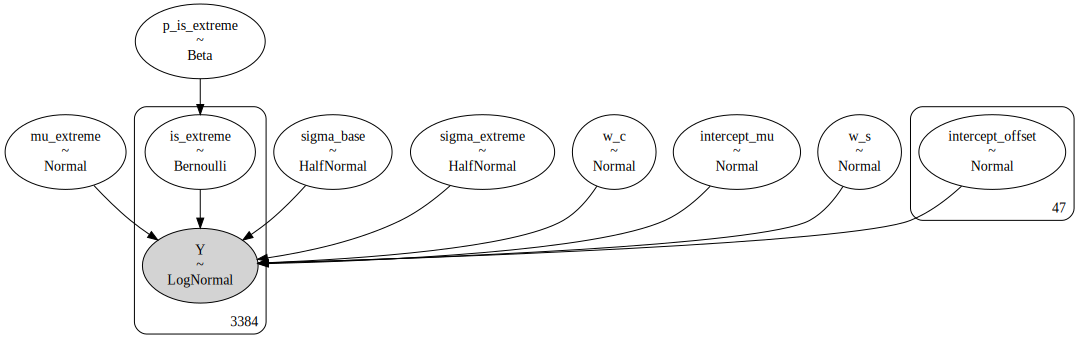

In [35]:
pm.model_to_graphviz(model_county_hierarchy)

In [36]:
az.summary(trace_county_hierarchy,
           var_names=['w_s', 
                      'w_c', 
                      'intercept_mu', 
                      'intercept_offset', 
                      'mu_extreme', 
                      'sigma_base', 
                      'sigma_extreme', 
                      'p_is_extreme'])


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
w_s                  -0.241  0.009  -0.258   -0.226      0.000    0.000   
w_c                   0.035  0.009   0.018    0.052      0.000    0.000   
intercept_mu          1.965  0.109   1.799    2.194      0.031    0.017   
intercept_offset[0]   0.047  0.116  -0.187    0.243      0.031    0.016   
intercept_offset[1]  -0.095  0.116  -0.338    0.094      0.031    0.017   
intercept_offset[2]  -0.182  0.115  -0.408    0.020      0.030    0.016   
intercept_offset[3]   0.047  0.116  -0.183    0.250      0.031    0.016   
intercept_offset[4]   0.084  0.115  -0.155    0.277      0.030    0.016   
intercept_offset[5]  -0.236  0.115  -0.457   -0.029      0.030    0.017   
intercept_offset[6]   0.261  0.117   0.023    0.461      0.031    0.016   
intercept_offset[7]  -0.169  0.115  -0.395    0.032      0.031    0.016   
intercept_offset[8]   0.238  0.115   0.000    0.421      0.030    0.017   
intercept_offset[9]  -0.295  0.115  -0.529   -0.093      0.030    0.017   
intercept_offset[10]  0.250  0.115   0.021    0.449      0.031    0.016   
intercept_offset[11]  0.506  0.117   0.266    0.700      0.031    0.016   
intercept_offset[12]  0.429  0.115   0.201    0.630      0.031    0.016   
intercept_offset[13]  0.297  0.117   0.056    0.504      0.031    0.016   
intercept_offset[14] -0.203  0.115  -0.435   -0.009      0.031    0.016   
intercept_offset[15] -0.259  0.117  -0.496   -0.057      0.031    0.016   
intercept_offset[16]  0.065  0.116  -0.158    0.276      0.031    0.016   
intercept_offset[17]  0.186  0.117  -0.049    0.386      0.031    0.016   
intercept_offset[18] -0.486  0.117  -0.734   -0.297      0.030    0.017   
intercept_offset[19] -0.378  0.115  -0.607   -0.183      0.031    0.017   
intercept_offset[20] -0.267  0.115  -0.492   -0.061      0.031    0.016   
intercept_offset[21]  0.299  0.116   0.062    0.493      0.031    0.016   
intercept_offset[22] -0.185  0.115  -0.416    0.012      0.031    0.017   
intercept_offset[23]  0.197  0.121  -0.039    0.403      0.032    0.013   
intercept_offset[24]  0.239  0.115   0.005    0.429      0.030    0.017   
intercept_offset[25]  0.026  0.116  -0.221    0.210      0.030    0.016   
intercept_offset[26] -0.372  0.116  -0.602   -0.176      0.031    0.017   
intercept_offset[27]  0.330  0.115   0.083    0.507      0.031    0.016   
intercept_offset[28]  0.230  0.116  -0.012    0.413      0.031    0.016   
intercept_offset[29] -0.036  0.115  -0.269    0.161      0.031    0.017   
intercept_offset[30]  0.076  0.117  -0.173    0.269      0.030    0.017   
intercept_offset[31] -0.205  0.115  -0.436   -0.005      0.030    0.017   
intercept_offset[32] -0.080  0.116  -0.316    0.116      0.031    0.016   
intercept_offset[33] -0.253  0.115  -0.484   -0.064      0.031    0.016   
intercept_offset[34]  0.064  0.115  -0.166    0.263      0.030    0.017   
intercept_offset[35] -0.287  0.115  -0.520   -0.092      0.031    0.017   
intercept_offset[36] -0.284  0.115  -0.511   -0.085      0.030    0.017   
intercept_offset[37] -0.337  0.118  -0.591   -0.151      0.031    0.016   
intercept_offset[38]  0.082  0.116  -0.157    0.278      0.031    0.016   
intercept_offset[39] -0.251  0.117  -0.497   -0.063      0.032    0.014   
intercept_offset[40]  0.324  0.117   0.087    0.526      0.031    0.016   
intercept_offset[41]  0.202  0.116  -0.024    0.398      0.031    0.016   
intercept_offset[42] -0.197  0.115  -0.434   -0.007      0.030    0.017   
intercept_offset[43] -0.121  0.123  -0.365    0.086      0.034    0.013   
intercept_offset[44]  0.437  0.117   0.196    0.632      0.031    0.015   
intercept_offset[45] -0.139  0.115  -0.363    0.063      0.030    0.016   
intercept_offset[46] -0.122  0.115  -0.349    0.081      0.031    0.017   
mu_extreme            3.037  0.242   2.648    3.396      0.071    0.007   
sigma_base            0.325  0.007   0.313    0.337      0.001    0.000   
sigma_extreme         0.711  0.149   0.492    0.

We see that some `r_hat` values are above 1.01, which suggests convergence issues. This can sometimes be improved by increasing the number of tuning steps, samples, or chains.

However, high `r_hat` might also suggest deeper issues with the model, like poor parameterization or parameters that aren’t well identified.

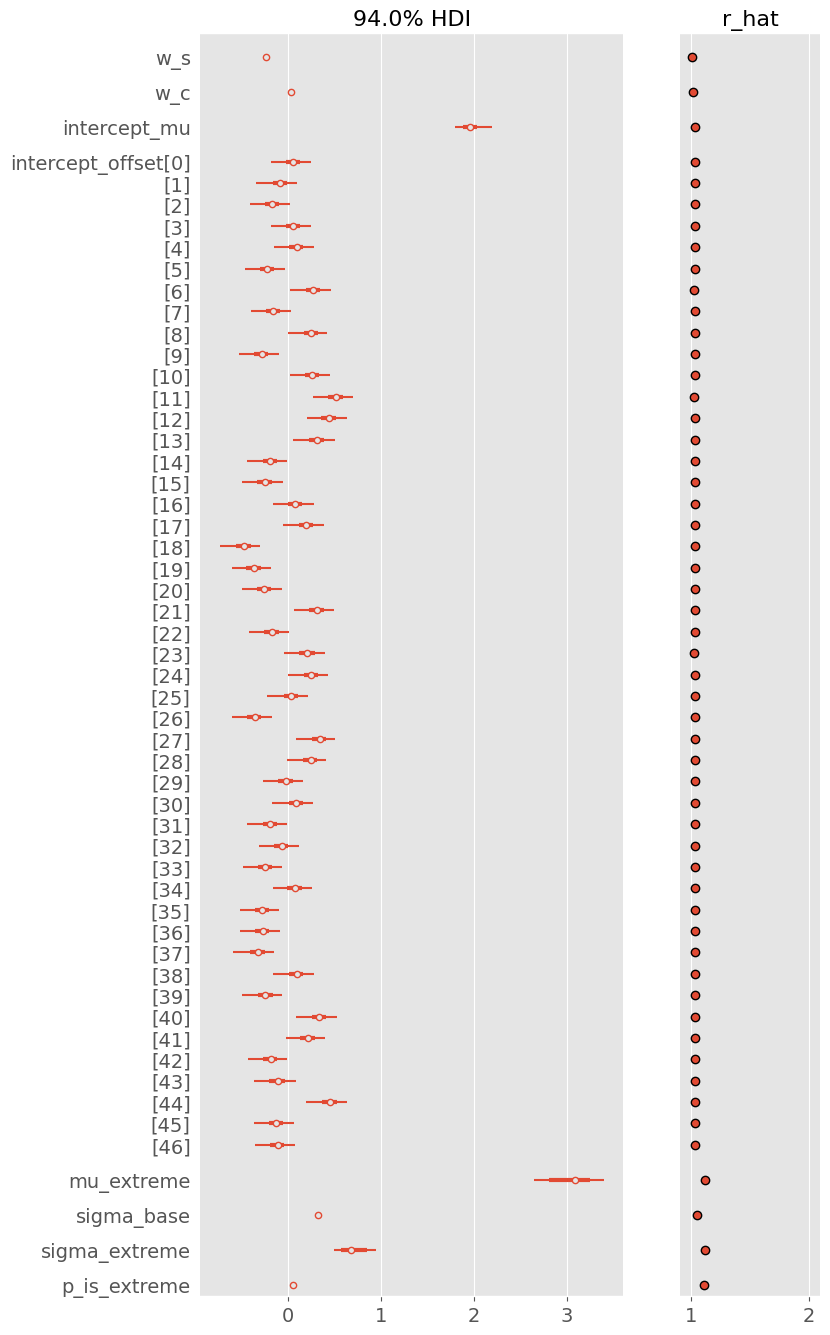

In [37]:
az.plot_forest(trace_county_hierarchy, 
               var_names=['w_s', 
                          'w_c', 
                          'intercept_mu', 
                          'intercept_offset', 
                          'mu_extreme', 
                          'sigma_base', 
                          'sigma_extreme', 
                          'p_is_extreme'], 
               combined=True, r_hat=True)
plt.show()

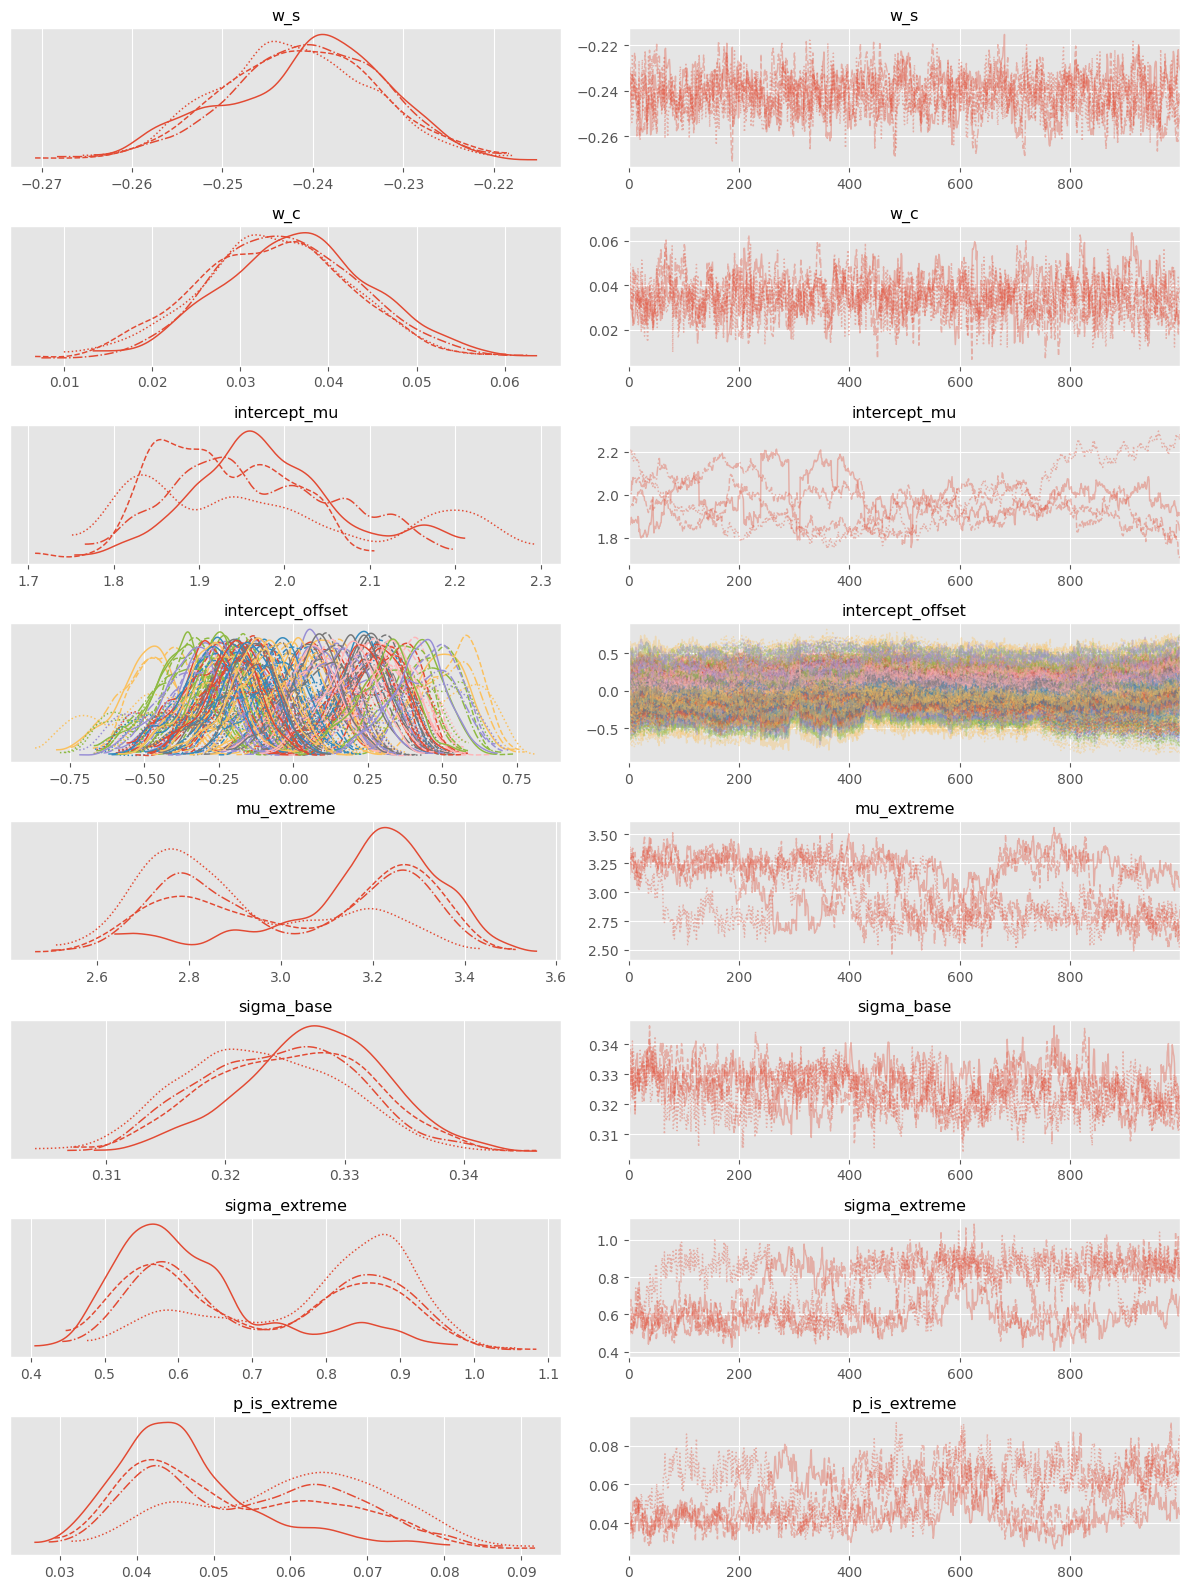

In [38]:
az.plot_trace(trace_county_hierarchy, 
              var_names=['w_s', 
                         'w_c', 
                         'intercept_mu', 
                         'intercept_offset', 
                         'mu_extreme', 
                         'sigma_base', 
                         'sigma_extreme', 
                         'p_is_extreme'], 
              compact=True)

plt.tight_layout()

## Model 3: County- and trend-hierarchy 

Since our model with county-specific intercepts still has some issues, we’ll now expand it by adding a trend component.

So far, we haven’t explicitly modeled any long-term trend. But interestingly, PM2.5 levels across the US have been __[declining overall](https://www.epa.gov/air-trends/particulate-matter-pm25-trends)__, while in California, the number and intensity of wildfires has increased (see __[here](https://emlab.ucsb.edu/sites/default/files/documents/wildfire-brief.pdf)__ and __[here](https://climateresilience.ca.gov/overview/impacts.html)__). That means while levels of PM2.5 are dropping on average, extreme spikes from wildfires are becoming more common.

To capture this, we’ll now give each county its own trend line over time.

In [39]:
with pm.Model() as model_county_trend_hierarchy:

    # --- Priors for seasonality ---
    sine = pm.math.sin(2 * np.pi * (monthly_avg["month_fraction"].values % 1))
    cosine = pm.math.cos(2 * np.pi * (monthly_avg["month_fraction"].values % 1))

    w_s = pm.Normal("w_s", mu=0, sigma=1)
    w_c = pm.Normal("w_c", mu=0, sigma=1)

    seasonality = sine * w_s + cosine * w_c

    # --- Priors for intercept ---
    intercept_mu = pm.Normal("intercept_mu", mu=0, sigma=5)  # wide prior on mean
    
    intercept_offset = pm.Normal("intercept_offset", mu=0, sigma=1, shape=n_counties)
    intercept_raw = intercept_mu + intercept_offset

    # intercept hierachy
    intercept = intercept_raw[monthly_avg['county_id']]

    # --- Priors for trend ---
    
    # Global average trend across all counties (centered at 0, wide prior)
    mu_trend = pm.Normal("mu_trend", mu=0, sigma=5)  
    
    # County-specific deviations from the global trend (one per county)
    trend_offset = pm.Normal("trend_offset", mu=0, sigma=1, shape=n_counties)
    
    # Combine global and county-specific components to get per-county trend slopes
    weight_trend = mu_trend + trend_offset
    
    # Match each observation to its county's trend slope and multiply by time
    trend = weight_trend[monthly_avg['county_id']] * monthly_avg["time_passed_total"].values

    # --- Modeling extreme events ---
    # We create a binary indicator variable 'is_extreme' to capture days with unusually high PM2.5.
    # The probability of an extreme event is modeled with a Beta prior to allow it to be low but flexible.
    
    p_is_extreme = pm.Beta("p_is_extreme", alpha=1, beta=50) # very narrow prior
    is_extreme = pm.Bernoulli("is_extreme", p_is_extreme, shape=monthly_avg.shape[0])  

    # --- Expected value of PM2.5 ---
    # The baseline expected log PM2.5 is the sum of intercept and seasonal effect (mu_base).
   
    mu_base = intercept + seasonality

    # For extreme events, we allow a separate, higher mean value (mu_extreme) with a fairly wide prior.
    mu_extreme = pm.Normal("mu_extreme", mu=5, sigma=5)

    # We switch between baseline and extreme expected values depending on 'is_extreme'.
    mu = pm.math.switch(is_extreme, mu_extreme, mu_base)

    # --- Priors for standard deviations ---
    # We model measurement noise or natural variability with two HalfNormal priors:
    # one for the baseline condition (sigma_base), and one for extreme events (sigma_extreme).

    sigma_base = pm.HalfNormal("sigma_base", sigma=1)
    sigma_extreme = pm.HalfNormal("sigma_extreme", sigma=1)

    # We switch the standard deviation based on 'is_extreme' status.

    sigma = pm.math.switch(is_extreme, sigma_extreme, sigma_base)

    # --- Likelihood ---
    Y = pm.LogNormal("Y", 
                    mu=mu, 
                    sigma=sigma, 
                    observed=monthly_avg['Monthly Avg PM2.5'])

    trace_county_trend_hierarchy = pm.sample(1000, tune=500, chains=4, cores=4, return_inferencedata=True)

    pm.compute_log_likelihood(trace_county_trend_hierarchy)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [w_s, w_c, intercept_mu, intercept_offset, mu_trend, trend_offset, p_is_extreme, mu_extreme, sigma_base, sigma_extreme]
>BinaryGibbsMetropolis: [is_extreme]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 534 seconds.
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [40]:
model_county_trend_hierarchy

             w_s ~ Normal(0, 1)
             w_c ~ Normal(0, 1)
    intercept_mu ~ Normal(0, 5)
intercept_offset ~ Normal(0, 1)
        mu_trend ~ Normal(0, 5)
    trend_offset ~ Normal(0, 1)
    p_is_extreme ~ Beta(1, 50)
      is_extreme ~ Bernoulli(p_is_extreme)
      mu_extreme ~ Normal(5, 5)
      sigma_base ~ HalfNormal(0, 1)
   sigma_extreme ~ HalfNormal(0, 1)
               Y ~ LogNormal(f(is_extreme, mu_extreme, intercept_offset, w_c, w_s, intercept_mu), f(is_extreme, sigma_extreme, sigma_base))

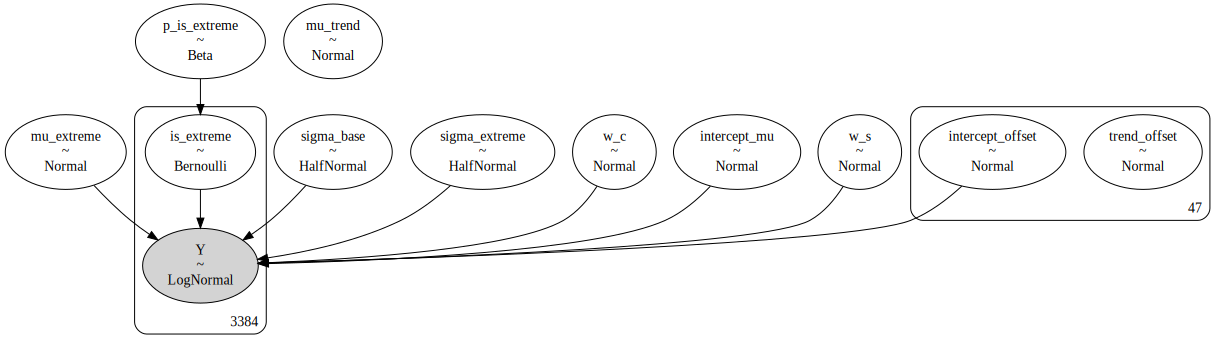

In [41]:
pm.model_to_graphviz(model_county_trend_hierarchy)

In [42]:
az.summary(trace_county_trend_hierarchy, 
           var_names=['w_s', 
                      'w_c', 
                      'intercept_mu', 
                      'intercept_offset', 
                      'mu_extreme', 
                      'sigma_base', 
                      'sigma_extreme', 
                      'p_is_extreme'])


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
w_s                  -0.241  0.008  -0.258   -0.226      0.000    0.000   
w_c                   0.035  0.009   0.019    0.051      0.000    0.000   
intercept_mu          1.957  0.150   1.683    2.231      0.024    0.010   
intercept_offset[0]   0.056  0.155  -0.216    0.349      0.024    0.010   
intercept_offset[1]  -0.086  0.155  -0.385    0.189      0.023    0.010   
intercept_offset[2]  -0.173  0.154  -0.448    0.126      0.024    0.009   
intercept_offset[3]   0.055  0.155  -0.217    0.359      0.024    0.008   
intercept_offset[4]   0.092  0.155  -0.190    0.388      0.024    0.009   
intercept_offset[5]  -0.226  0.155  -0.508    0.057      0.024    0.009   
intercept_offset[6]   0.268  0.155  -0.024    0.550      0.024    0.009   
intercept_offset[7]  -0.159  0.156  -0.442    0.128      0.024    0.009   
intercept_offset[8]   0.246  0.154  -0.031    0.532      0.023    0.009   
intercept_offset[9]  -0.284  0.155  -0.560    0.011      0.024    0.009   
intercept_offset[10]  0.258  0.155  -0.020    0.544      0.024    0.010   
intercept_offset[11]  0.512  0.157   0.226    0.810      0.024    0.010   
intercept_offset[12]  0.437  0.155   0.169    0.741      0.022    0.009   
intercept_offset[13]  0.306  0.154   0.025    0.596      0.023    0.008   
intercept_offset[14] -0.195  0.153  -0.462    0.102      0.023    0.010   
intercept_offset[15] -0.250  0.156  -0.537    0.036      0.024    0.008   
intercept_offset[16]  0.074  0.155  -0.206    0.364      0.024    0.008   
intercept_offset[17]  0.196  0.155  -0.082    0.490      0.024    0.010   
intercept_offset[18] -0.469  0.155  -0.767   -0.194      0.024    0.009   
intercept_offset[19] -0.368  0.153  -0.640   -0.072      0.023    0.009   
intercept_offset[20] -0.260  0.155  -0.538    0.038      0.024    0.009   
intercept_offset[21]  0.307  0.154   0.015    0.589      0.023    0.010   
intercept_offset[22] -0.176  0.155  -0.461    0.111      0.024    0.008   
intercept_offset[23]  0.193  0.158  -0.084    0.494      0.023    0.008   
intercept_offset[24]  0.248  0.155  -0.042    0.526      0.024    0.010   
intercept_offset[25]  0.035  0.156  -0.247    0.324      0.024    0.011   
intercept_offset[26] -0.360  0.155  -0.627   -0.055      0.024    0.008   
intercept_offset[27]  0.337  0.155   0.055    0.632      0.023    0.010   
intercept_offset[28]  0.237  0.154  -0.020    0.556      0.023    0.009   
intercept_offset[29] -0.028  0.155  -0.326    0.244      0.023    0.009   
intercept_offset[30]  0.087  0.156  -0.198    0.377      0.024    0.009   
intercept_offset[31] -0.192  0.155  -0.452    0.115      0.024    0.009   
intercept_offset[32] -0.071  0.155  -0.343    0.226      0.023    0.008   
intercept_offset[33] -0.244  0.153  -0.520    0.041      0.024    0.008   
intercept_offset[34]  0.072  0.154  -0.203    0.366      0.024    0.010   
intercept_offset[35] -0.278  0.155  -0.543    0.027      0.024    0.008   
intercept_offset[36] -0.272  0.155  -0.558    0.009      0.024    0.009   
intercept_offset[37] -0.326  0.157  -0.622   -0.039      0.024    0.009   
intercept_offset[38]  0.089  0.155  -0.187    0.396      0.025    0.009   
intercept_offset[39] -0.252  0.155  -0.529    0.036      0.022    0.010   
intercept_offset[40]  0.332  0.156   0.043    0.615      0.023    0.009   
intercept_offset[41]  0.213  0.156  -0.080    0.493      0.024    0.009   
intercept_offset[42] -0.187  0.155  -0.453    0.110      0.024    0.011   
intercept_offset[43] -0.132  0.157  -0.413    0.161      0.023    0.011   
intercept_offset[44]  0.444  0.156   0.154    0.726      0.023    0.010   
intercept_offset[45] -0.128  0.154  -0.411    0.156      0.023    0.008   
intercept_offset[46] -0.111  0.155  -0.381    0.189      0.024    0.009   
mu_extreme            3.219  0.146   2.889    3.435      0.016    0.015   
sigma_base            0.329  0.005   0.319    0.339      0.000    0.000   
sigma_extreme         0.604  0.094   0.455    0.

In [43]:
az.summary(trace_county_trend_hierarchy, 
           var_names=['mu_trend',
                      'trend_offset']) 

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_trend         -0.048  4.860  -9.638    8.729      0.059    0.081    6656.0   
trend_offset[0]   0.007  0.998  -1.918    1.852      0.011    0.019    8296.0   
trend_offset[1]  -0.015  0.983  -1.862    1.763      0.012    0.017    6712.0   
trend_offset[2]   0.005  0.977  -1.776    1.765      0.012    0.016    6814.0   
trend_offset[3]   0.016  0.998  -1.760    1.931      0.011    0.020    8284.0   
trend_offset[4]  -0.003  0.978  -1.784    1.882      0.011    0.016    8551.0   
trend_offset[5]   0.010  0.998  -1.828    1.854      0.012    0.017    7223.0   
trend_offset[6]   0.012  1.004  -1.818    1.905      0.011    0.019    8841.0   
trend_offset[7]   0.002  1.031  -1.857    1.990      0.010    0.020   10246.0   
trend_offset[8]   0.005  0.984  -1.825    1.845      0.012    0.017    7320.0   
trend_offset[9]   0.019  1.008  -1.927    1.805      0.012    0.018    7072.0   
trend_offset[10]  0.013  0.992  -1.835    1.856      0.011    0.019    7833.0   
trend_offset[11] -0.006  1.017  -1.719    2.025      0.011    0.018    7913.0   
trend_offset[12] -0.004  0.974  -1.738    1.868      0.011    0.018    7496.0   
trend_offset[13] -0.010  1.005  -1.922    1.867      0.010    0.021   10291.0   
trend_offset[14] -0.014  0.979  -1.881    1.785      0.012    0.016    7148.0   
trend_offset[15] -0.019  1.021  -1.880    1.983      0.011    0.018    8611.0   
trend_offset[16] -0.010  0.984  -1.732    1.968      0.013    0.016    5570.0   
trend_offset[17] -0.012  1.009  -1.893    1.844      0.011    0.020    8181.0   
trend_offset[18]  0.010  1.000  -1.881    1.814      0.011    0.019    7942.0   
trend_offset[19]  0.007  0.988  -1.854    1.880      0.012    0.018    7239.0   
trend_offset[20] -0.009  0.993  -1.890    1.770      0.012    0.017    6675.0   
trend_offset[21] -0.009  1.034  -1.992    1.953      0.011    0.021    8728.0   
trend_offset[22]  0.007  1.007  -1.895    1.843      0.011    0.020    8911.0   
trend_offset[23] -0.006  1.012  -1.882    1.865      0.011    0.017    8873.0   
trend_offset[24]  0.003  0.977  -1.865    1.818      0.012    0.016    6980.0   
trend_offset[25] -0.024  1.049  -1.908    1.986      0.013    0.019    6617.0   
trend_offset[26] -0.013  0.986  -1.868    1.869      0.011    0.017    7720.0   
trend_offset[27] -0.003  1.006  -1.877    1.869      0.011    0.018    7860.0   
trend_offset[28]  0.012  1.031  -1.945    1.961      0.010    0.021   10709.0   
trend_offset[29]  0.007  0.996  -1.911    1.843      0.010    0.017    9080.0   
trend_offset[30]  0.010  0.976  -1.877    1.766      0.011    0.018    8580.0   
trend_offset[31]  0.002  0.989  -1.878    1.800      0.010    0.017    9105.0   
trend_offset[32] -0.012  0.970  -1.849    1.784      0.012    0.016    6803.0   
trend_offset[33]  0.017  1.013  -1.868    1.977      0.012    0.023    7239.0   
trend_offset[34]  0.001  0.981  -1.827    1.797      0.011    0.017    8117.0   
trend_offset[35] -0.013  1.006  -1.942    1.790      0.012    0.019    6585.0   
trend_offset[36]  0.008  1.002  -1.776    1.969      0.010    0.018    9115.0   
trend_offset[37] -0.012  0.982  -1.964    1.729      0.012    0.016    7039.0   
trend_offset[38] -0.011  0.995  -1.846    1.906      0.011    0.018    8552.0   
trend_offset[39] -0.001  1.027  -1.975    1.879      0.011    0.020    8764.0   
trend_offset[40] -0.003  0.974  -1.786    1.845      0.011    0.018    8336.0   
trend_offset[41]  0.032  1.004  -2.001    1.787      0.011    0.019    7963.0   
trend_offset[42] -0.002  1.003  -1.874    1.932      0.012    0.017    6496.0   
trend_offset[43]  0.002  0.988  -1.797    1.922      0.012    0.017    6537.0   
trend_offset[44]  0.004  0.970  -1.907    1.762      0.012    0.016    6931.0   
trend_offset[45]  0.003  0.991  -1.827    1.853      0.011    0.017    7716.0   
trend_offset[46]  0.016  1.000  -1.846    1.925      0.011    0.019    8301.0   

                  ess_tail  r_hat  
mu_trend     

This looks better than the model with only county intercepts. `r_hat` is still above 1.01 for some parameters, but that might go away if we increase the number of tuning steps or samples.

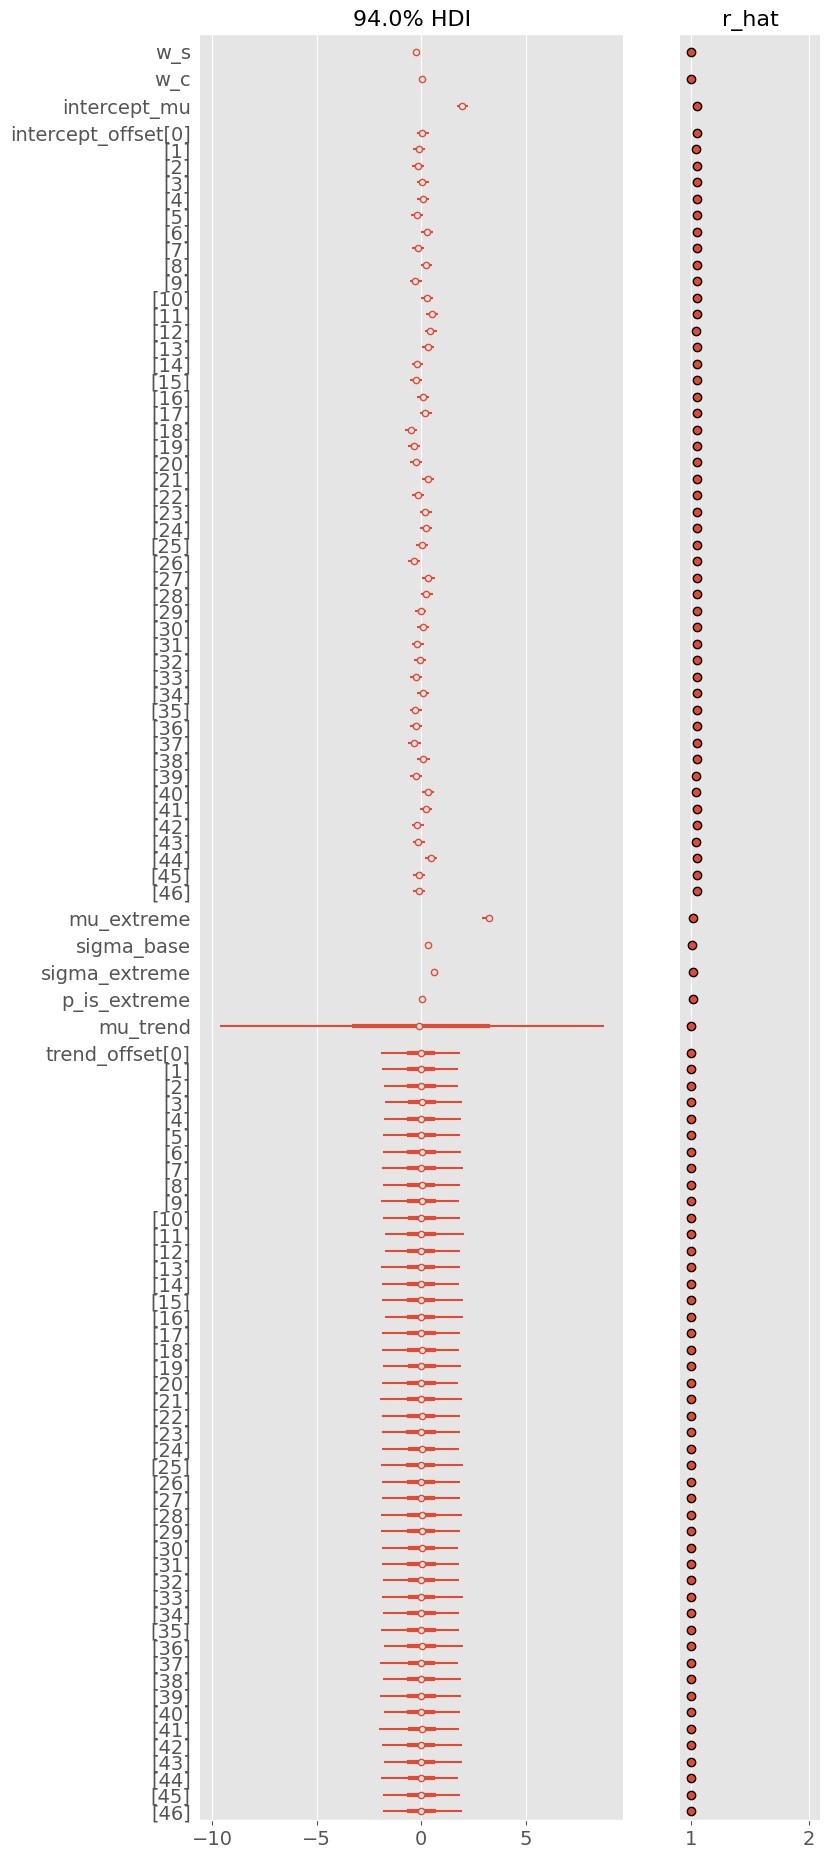

In [44]:
az.plot_forest(trace_county_trend_hierarchy, 
               var_names=['w_s', 
                          'w_c', 
                          'intercept_mu', 
                          'intercept_offset', 
                          'mu_extreme', 
                          'sigma_base', 
                          'sigma_extreme', 
                          'p_is_extreme', 
                          'mu_trend',
                          'trend_offset'], 
               combined=True, 
               r_hat=True)

plt.show()

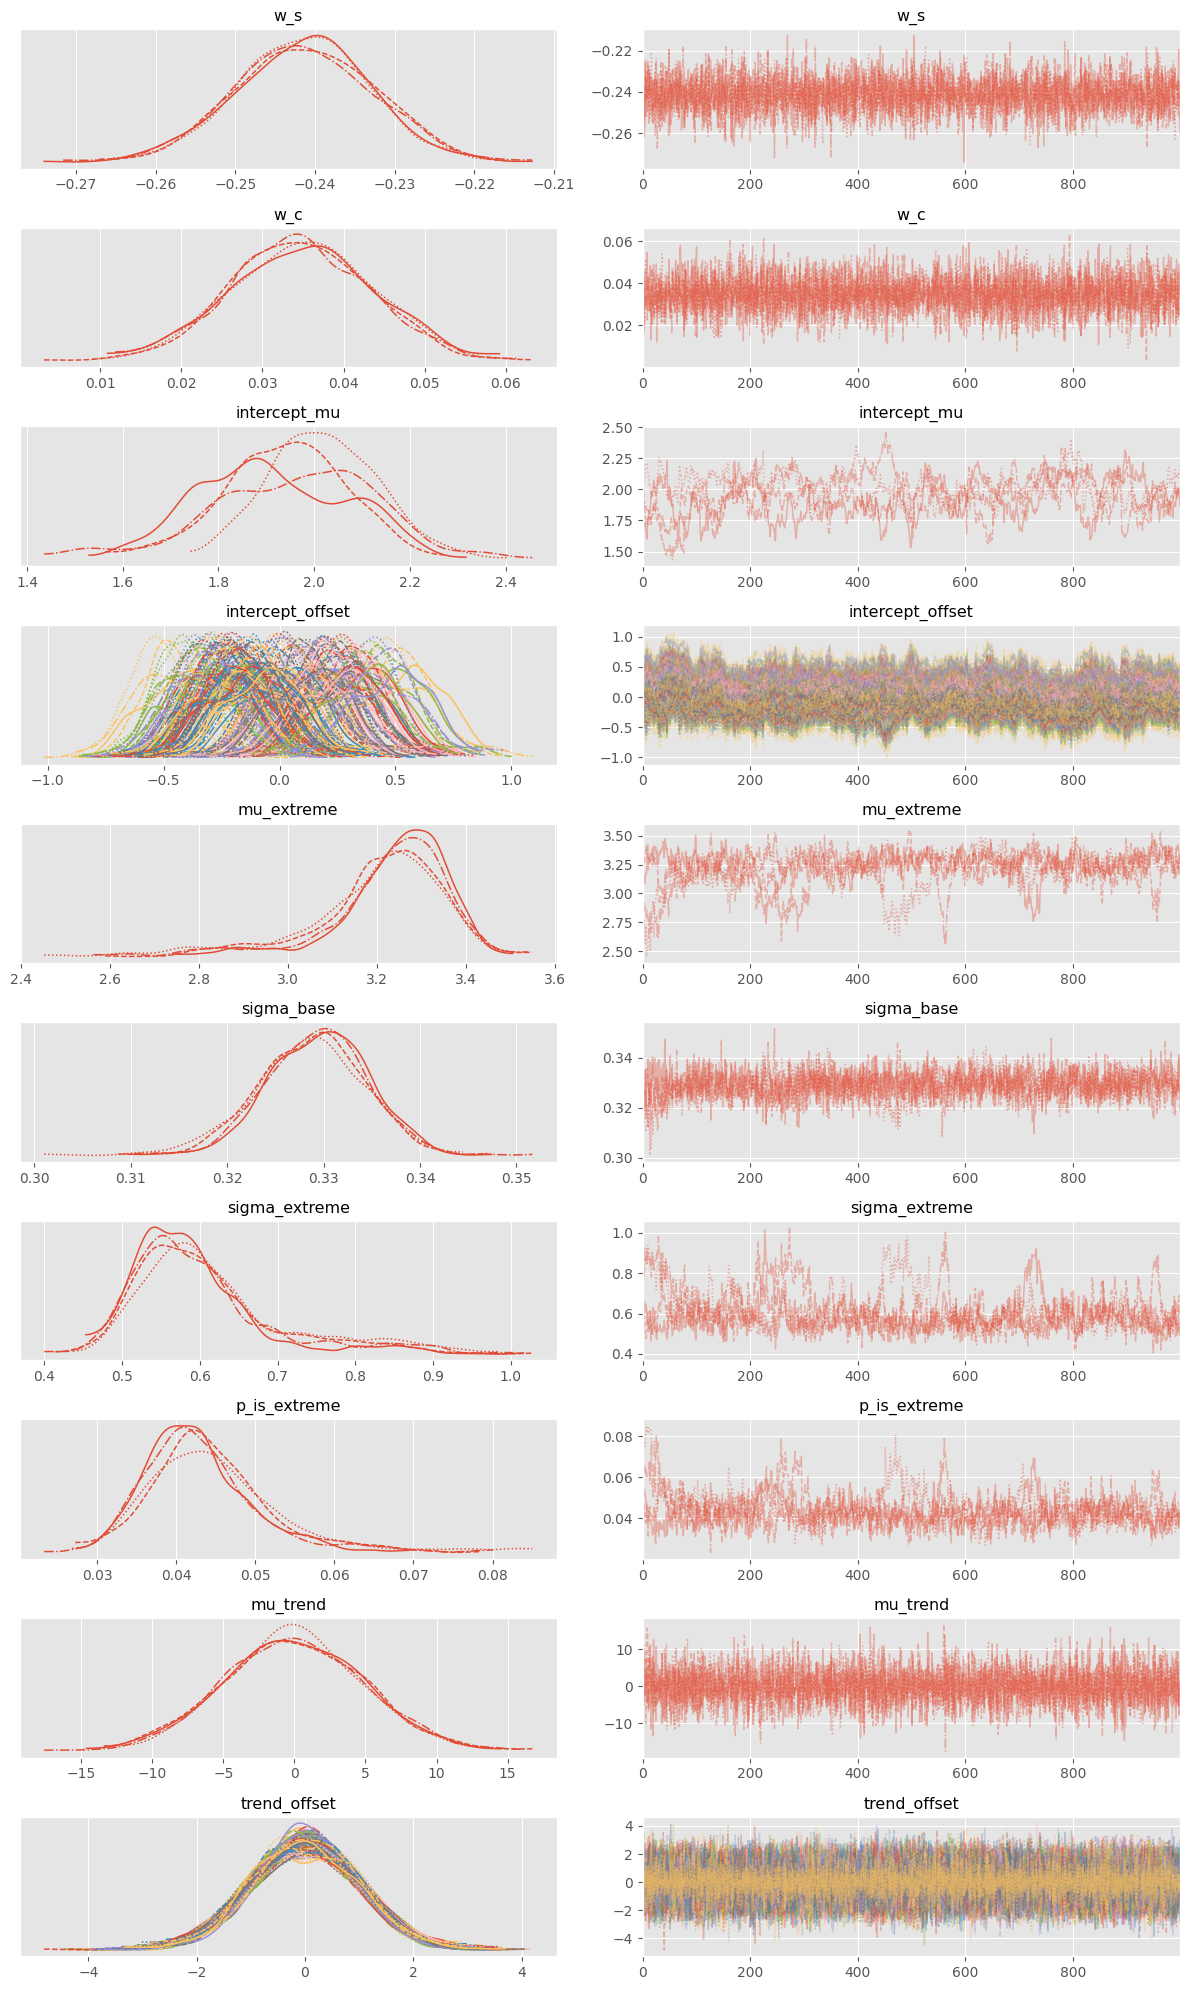

In [45]:
az.plot_trace(trace_county_trend_hierarchy, 
              var_names=['w_s', 
                          'w_c', 
                          'intercept_mu', 
                          'intercept_offset', 
                          'mu_extreme', 
                          'sigma_base', 
                          'sigma_extreme', 
                          'p_is_extreme', 
                          'mu_trend',
                          'trend_offset'], 
              compact=True)

plt.tight_layout()

## Generating predictions based on posterior distribution of the model

We now have 3 models of different complexity. So far we’ve looked at convergence diagnostics, but we haven’t yet compared their predictions.

In [46]:
models = {
    "model_no_hierarchy": {"model": model_no_hierarchy, "trace": trace_no_hierarchy},
    "model_county_hierarchy": {"model": model_county_hierarchy, "trace": trace_county_hierarchy},
    "model_county_trend_hierarchy": {"model": model_county_trend_hierarchy, "trace": trace_county_trend_hierarchy},
}

for label, items in models.items():
    ppc = pm.sample_posterior_predictive(items["trace"], model=items["model"], var_names=["Y"])
    items["ppc"] = ppc.posterior_predictive["Y"].values

Sampling: [Y]


Output()

Sampling: [Y]


Output()

Sampling: [Y]


Output()

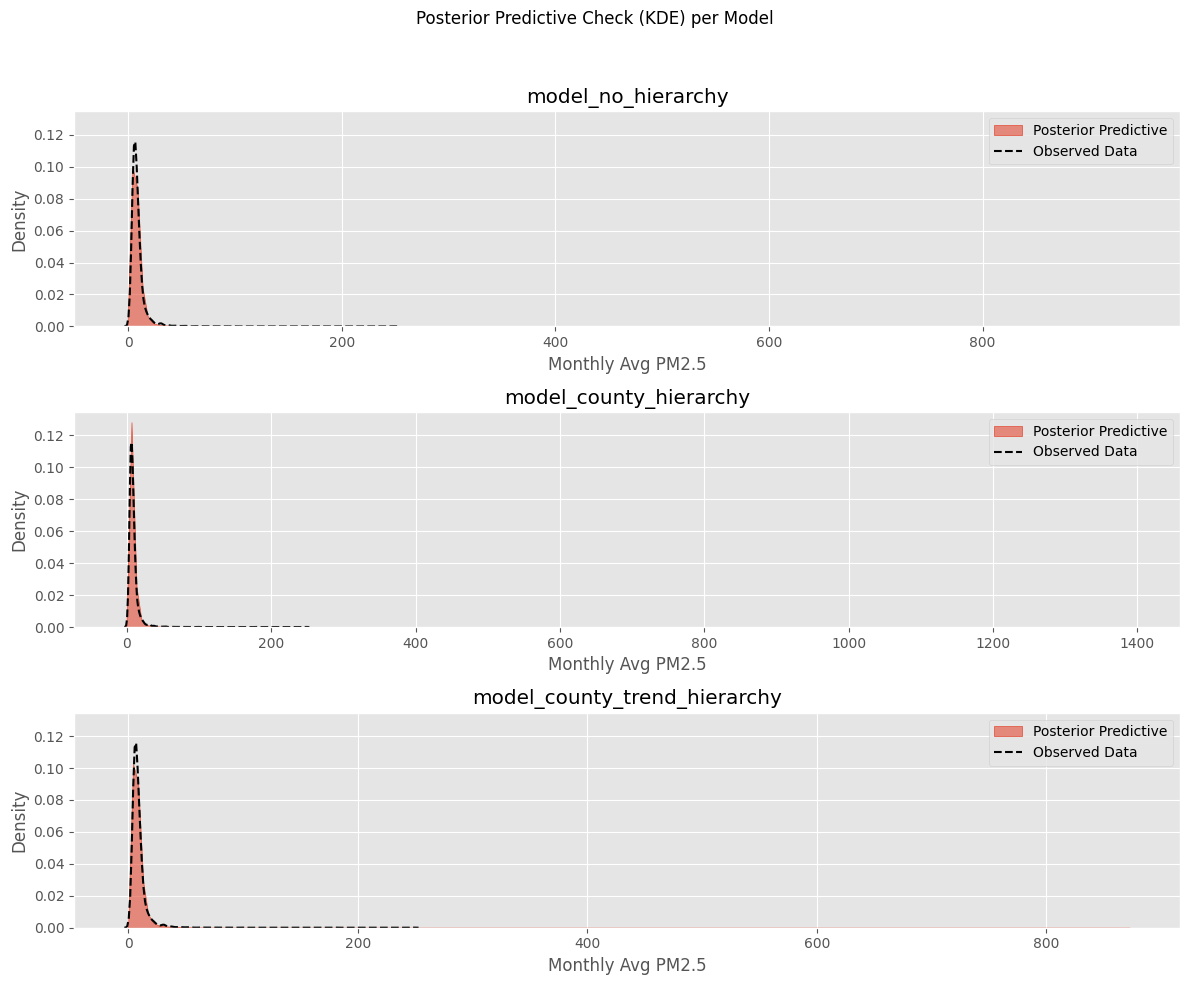

In [47]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharey=True)

for ax, (label, items) in zip(axes, models.items()):
    samples = items["ppc"].flatten()
    sns.kdeplot(samples, ax=ax, label="Posterior Predictive", fill=True, alpha=0.6)
    sns.kdeplot(monthly_avg["Monthly Avg PM2.5"], ax=ax, label="Observed Data", color="black", linestyle="--")
    
    ax.set_title(label)
    ax.set_xlabel("Monthly Avg PM2.5")
    ax.set_ylabel("Density")
    ax.legend()

axes[2].set_xlabel("Monthly Avg PM2.5") 
plt.suptitle("Posterior Predictive Check (KDE) per Model")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


This figure visually compares the distribution of model-predicted values (orange shade) with the actual observed data (dashed black line). The comparison is based on predictions derived from the model's posterior distribution, checked against the observed data to assess consistency. The misalignment between the two distributions at their peaks and tails suggests that the model may have difficulty accurately predicting certain data points, i.e. outliers.

### Compute predictions

We will compute the mean of the posterior predictive samples to obtain predictions and calculate percentiles from these samples to represent prediction uncertainty. Although the Bayesian approach also allows for determining credible intervals for model parameters to assess their uncertainty, I will focus on using percentiles of the predictions for easier data visualization.

In [48]:
for label, items in models.items():
    ppc_samples = items["ppc"]  # posterior predictive samples: shape (chains, draws, obs)
    trace = items["trace"]
    
    # Average over chains and draws to get predicted means for each observation
    predicted_means = ppc_samples.mean(axis=0).mean(axis=0)
    items["predicted_means"] = predicted_means
    
    # Mean of is_extreme across chains and draws for each observation
    is_extreme_mean = trace.posterior["is_extreme"].mean(dim=["chain", "draw"]).values
    items["is_extreme_mean"] = is_extreme_mean
    
    # Calculate 2.5% and 97.5% quantiles for credible intervals
    lower_bound = np.percentile(ppc_samples.mean(axis=0), 2.5, axis=0)
    upper_bound = np.percentile(ppc_samples.mean(axis=0), 97.5, axis=0)
    items["lower_bound"] = lower_bound
    items["upper_bound"] = upper_bound


In [49]:
model_names = ['model_no_hierarchy', 'model_county_hierarchy', 'model_county_trend_hierarchy']
columns = ['predicted_means', 'lower_bound', 'upper_bound', 'is_extreme_mean']

for model in model_names:
    for col in columns:
        monthly_avg[f'{col}_{model.replace("model_", "")}'] = models[model][col]


### Calculate r2 scores

In [50]:
r2_results = {}

# Get unique counties and their names once
county_map = monthly_avg.drop_duplicates(subset=['county_id'])[['county_id', 'County']].set_index('county_id')['County']

county_ids = monthly_avg['county_id'].unique()

for model_label, items in models.items():
    r2_scores = []
    preds = items['predicted_means']  # predicted means array, length = number of observations
    
    for county_id in county_ids:
        mask = (monthly_avg['county_id'] == county_id)
        y_obs = monthly_avg.loc[mask, 'Monthly Avg PM2.5'].values
        y_pred = preds[mask.values]  # mask.values to align boolean index with numpy array
        
        r2 = r2_score(y_obs, y_pred)
        r2_scores.append(r2)
    
    r2_results[model_label] = r2_scores
    
    county_to_r2 = dict(zip(county_ids, r2_scores))
    
    monthly_avg[f'r2_{model_label}'] = monthly_avg['county_id'].map(county_to_r2)


In [51]:
monthly_avg[monthly_avg["County"]=="Los Angeles"]

County year_month  Monthly Avg PM2.5 first_date  time_passed_total  \
864  Los Angeles 2019-01-01          10.252311 2019-01-01           0.000000   
865  Los Angeles 2019-02-01           6.953476 2019-01-01           0.084932   
866  Los Angeles 2019-03-01           6.954916 2019-01-01           0.161644   
867  Los Angeles 2019-04-01           9.236855 2019-01-01           0.246575   
868  Los Angeles 2019-05-01           8.548926 2019-01-01           0.328767   
..           ...        ...                ...        ...                ...   
931  Los Angeles 2024-08-01          10.952798 2019-01-01           5.586301   
932  Los Angeles 2024-09-01          11.196954 2019-01-01           5.671233   
933  Los Angeles 2024-10-01          13.222716 2019-01-01           5.753425   
934  Los Angeles 2024-11-01          10.320647 2019-01-01           5.838356   
935  Los Angeles 2024-12-01          18.838500 2019-01-01           5.920548   

     month  month_fraction  county_id  predicted_means_no_hierarchy  \
864      1        0.000000         12                      7.952516   
865      2        0.083333         12                      6.967165   
866      3        0.166667         12                      6.286816   
867      4        0.250000         12                      6.168651   
868      5        0.333333         12                      6.359948   
..     ...             ...        ...                           ...   
931      8        0.583333         12                      8.833353   
932      9        0.666667         12                      9.974044   
933     10        0.750000         12                     10.394671   
934     11        0.833333         12                     10.196489   
935     12        0.916667         12                     11.800792   

     lower_bound_no_hierarchy  ...  lower_bound_county_hierarchy  \
864                  4.994085  ...                      8.354483   
865                  4.458014  ...                      7.386780   
866                  3.961302  ...                      6.593042   
867                  3.826217  ...                      6.437263   
868                  3.971555  ...                      6.573303   
..                        ...  ...                           ...   
931                  5.401123  ...                      8.958051   
932                  6.199721  ...                     10.139478   
933                  6.577448  ...                     10.705057   
934                  6.472553  ...                     10.346237   
935                  6.093555  ...                      9.556258   

     upper_bound_county_hierarchy  is_extreme_mean_county_hierarchy  \
864                     17.145199                           0.01525   
865                     14.963297                           0.01500   
866                     14.075726                           0.01300   
867                     13.011563                           0.01350   
868                     13.445384                           0.01175   
..                            ...                               ...   
931                     17.949339                           0.01650   
932                     20.107862                           0.01600   
933                     21.779937                           0.02125   
934                     20.618348                           0.01925   
935                     22.027736                           0.05225   

     predicted_means_county_trend_hierarchy  \
864                               12.016287   
865                               10.633781   
866                                9.633999   
867                                9.147699   
868                                9.276825   
..                                      ...   
931                               12.905095   
932                               14.104163   
933                               14.851238   
934                               14.657513   
935      

### Observed vs Predicted plot for each county

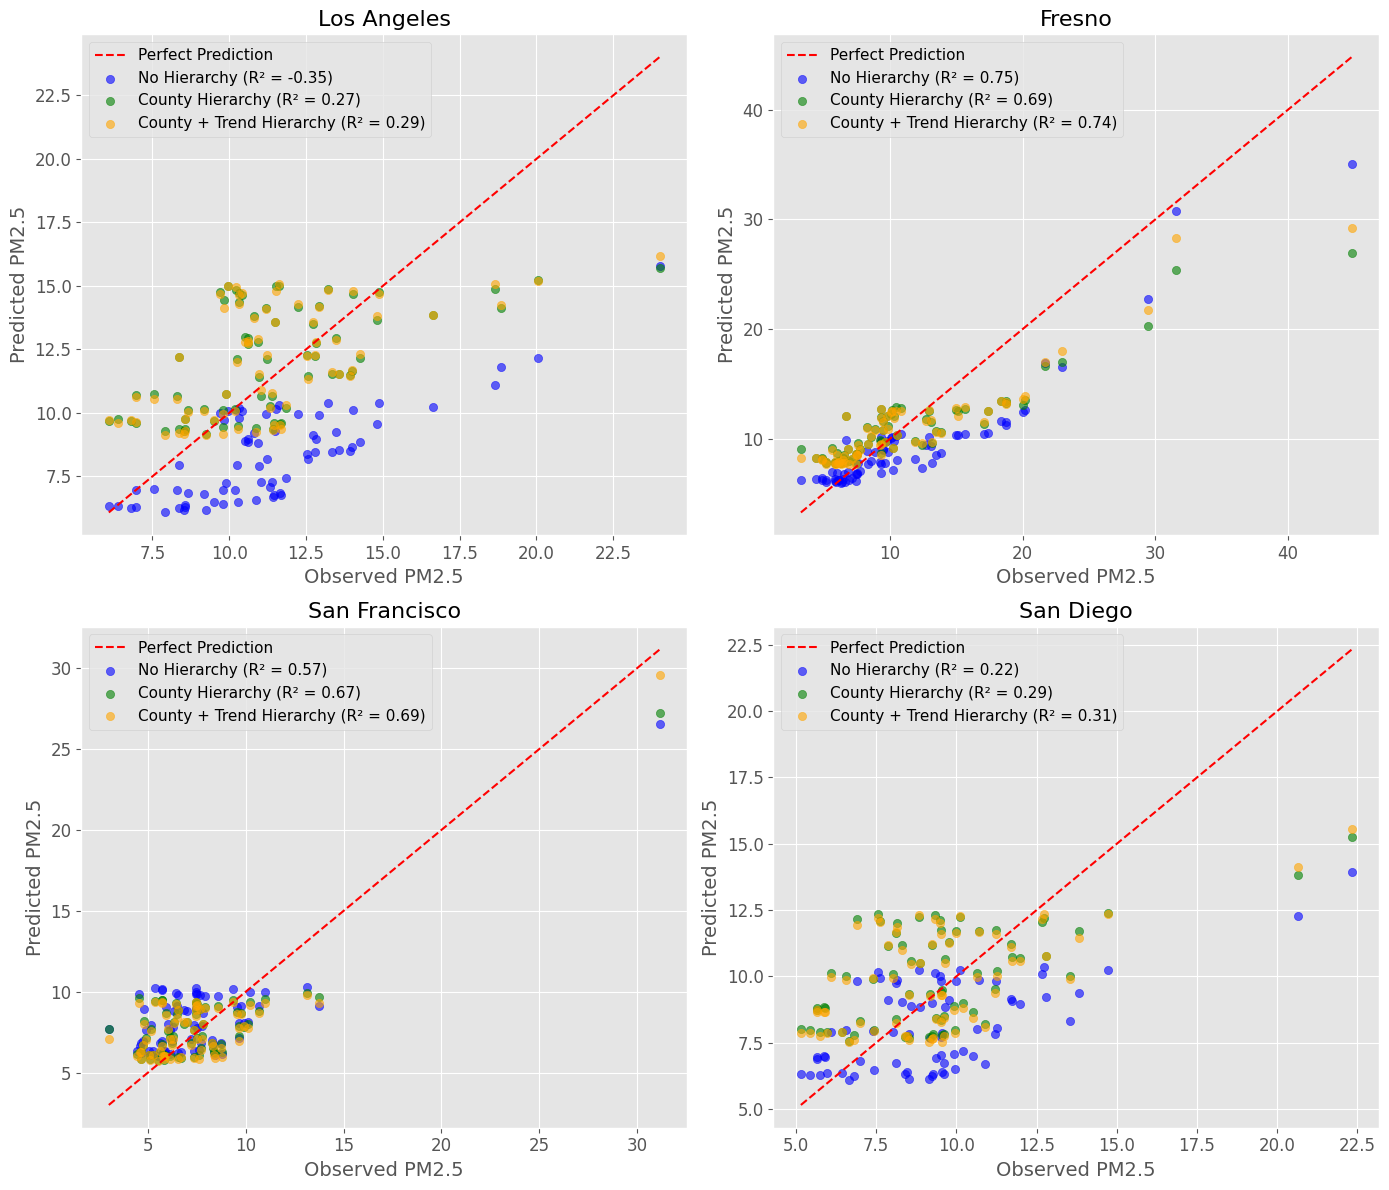

In [53]:
plot_counties = ['Los Angeles', 'Fresno', 'San Francisco', 'San Diego']
filtered_data = monthly_avg[monthly_avg['County'].isin(plot_counties)]

model_to_column = {
    "No Hierarchy": "predicted_means_no_hierarchy",
    "County Hierarchy": "predicted_means_county_hierarchy",
    "County + Trend Hierarchy": "predicted_means_county_trend_hierarchy",
}

model_to_r2_col = {
    "No Hierarchy": "r2_model_no_hierarchy",
    "County Hierarchy": "r2_model_county_hierarchy",
    "County + Trend Hierarchy": "r2_model_county_trend_hierarchy",
}

colors = {
    "No Hierarchy": "blue",
    "County Hierarchy": "green",
    "County + Trend Hierarchy": "orange",
}

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, county in zip(axes, plot_counties):
    county_data = filtered_data[filtered_data["County"] == county]

    min_val = min(county_data['Monthly Avg PM2.5'].min(), *(county_data[col].min() for col in model_to_column.values()))
    max_val = max(county_data['Monthly Avg PM2.5'].max(), *(county_data[col].max() for col in model_to_column.values()))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    for model_label, pred_col in model_to_column.items():
        r2_val = county_data[model_to_r2_col[model_label]].iloc[0]
        ax.scatter(
            county_data["Monthly Avg PM2.5"],
            county_data[pred_col],
            label=f"{model_label} (R² = {r2_val:.2f})",
            color=colors[model_label],
            alpha=0.6,
            s=35,
        )

    ax.set_title(county, fontsize=16)
    ax.set_xlabel("Observed PM2.5", fontsize=14)
    ax.set_ylabel("Predicted PM2.5", fontsize=14)
    ax.legend(fontsize=11)
    ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


This plot compares the observed data (x-axis) with the predicted values (y-axis) generated by 3 model for 4 different cities. The diagonal red dashed line represents the line of perfect prediction. Points close to this line indicate better predictions, while scattered points indicate more significant discrepancies between the model’s predictions and the observed data.

### Predictions for each county

In [54]:
# helper function for plotting

def plot_model_predictions(data, model_col, lower_col, upper_col, is_extreme_col, plot_counties, title_suffix):
    filtered_data = data[data['County'].isin(plot_counties)].copy()
    filtered_data = filtered_data.rename(columns={
        model_col: 'predicted_means',
        lower_col: 'lower_bound',
        upper_col: 'upper_bound',
        is_extreme_col: 'is_extreme',
    })

    g = sns.FacetGrid(filtered_data, col='County', col_wrap=2, height=5, aspect=1.5, sharex=False, sharey=False)
    
    # Disable automatic legend in these plots:
    g.map(sns.scatterplot, 'year_month', 'Monthly Avg PM2.5', label='observations', color='black', alpha=0.7, legend=False)
    g.map(sns.lineplot, 'year_month', 'predicted_means', label='predictions', color='cornflowerblue', alpha=0.7, legend=False)

    fill_patch = patches.Patch(color='lightblue', alpha=0.5, label='95% Percentile')

    legend_handles = []
    legend_labels = []

    for ax, (region, subset) in zip(g.axes.flat, filtered_data.groupby('County')):
        ax.fill_between(subset['year_month'], 
                        subset['lower_bound'],
                        subset['upper_bound'], 
                        color='lightblue', alpha=0.5)

        ax2 = ax.twinx()
        ax2.set_ylabel('P(is extreme)', fontsize=12)
        ax2.set_ylim(0, 1)
        
        # Disable automatic legend here too:
        sns.lineplot(data=subset, x='year_month', y='is_extreme', ax=ax2, color='red', alpha=0.7, label='P(is extreme)', legend=False)
        
        if ax == g.axes.flat[0]:
            h1, l1 = ax.get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            legend_handles.extend(h1)
            legend_labels.extend(l1)
            legend_handles.extend(h2)
            legend_labels.extend(l2)

    legend_handles.append(fill_patch)
    legend_labels.append('95% Percentile')

    for ax, title in zip(g.axes.flat, g.col_names):
        ax.set_title(title, fontsize=16)

    for i, ax in enumerate(g.axes.flat):
        x_label = 'year_month' if i in [2, 3] else ''
        y_label = 'Monthly Avg PM2.5' if i in [0, 2] else ''
        ax.set_xlabel(x_label, fontsize=16 if x_label else None)
        ax.set_ylabel(y_label, fontsize=16 if y_label else None)
        ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
        ax.tick_params(axis='x', rotation=45)

    first_ax = g.axes.flat[0]
    first_ax.legend(legend_handles, legend_labels, fontsize=14, loc='upper right')

    plt.subplots_adjust(top=0.9)
    fig = g.figure
    fig.suptitle(f"Model Predictions: {title_suffix}", fontsize=20)

    plt.tight_layout()
    plt.show()


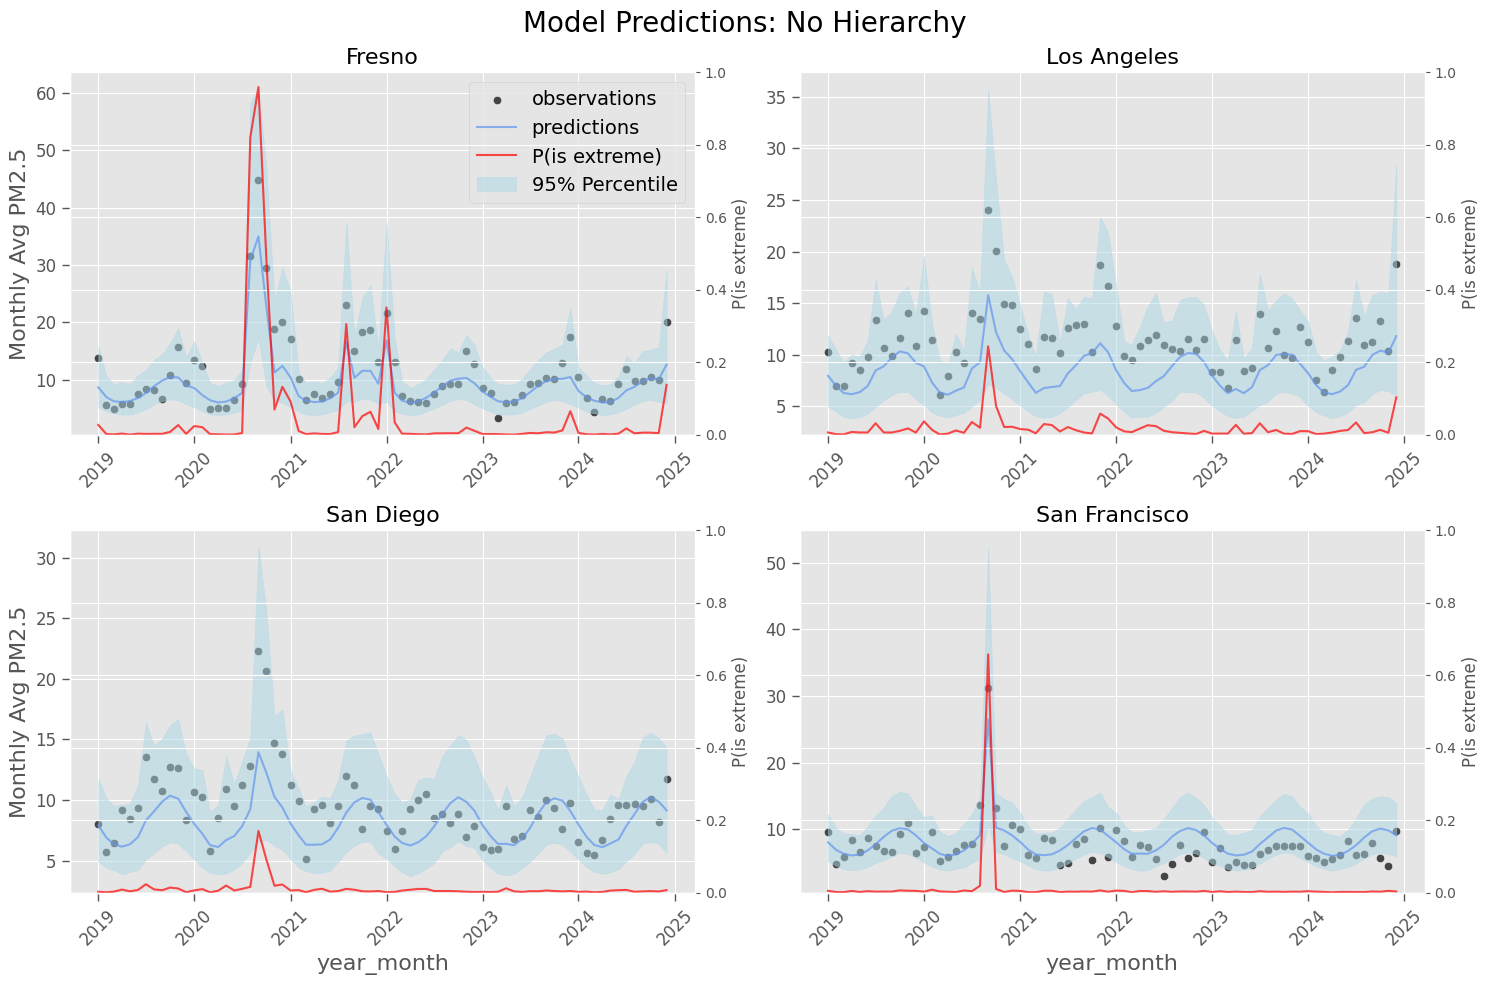

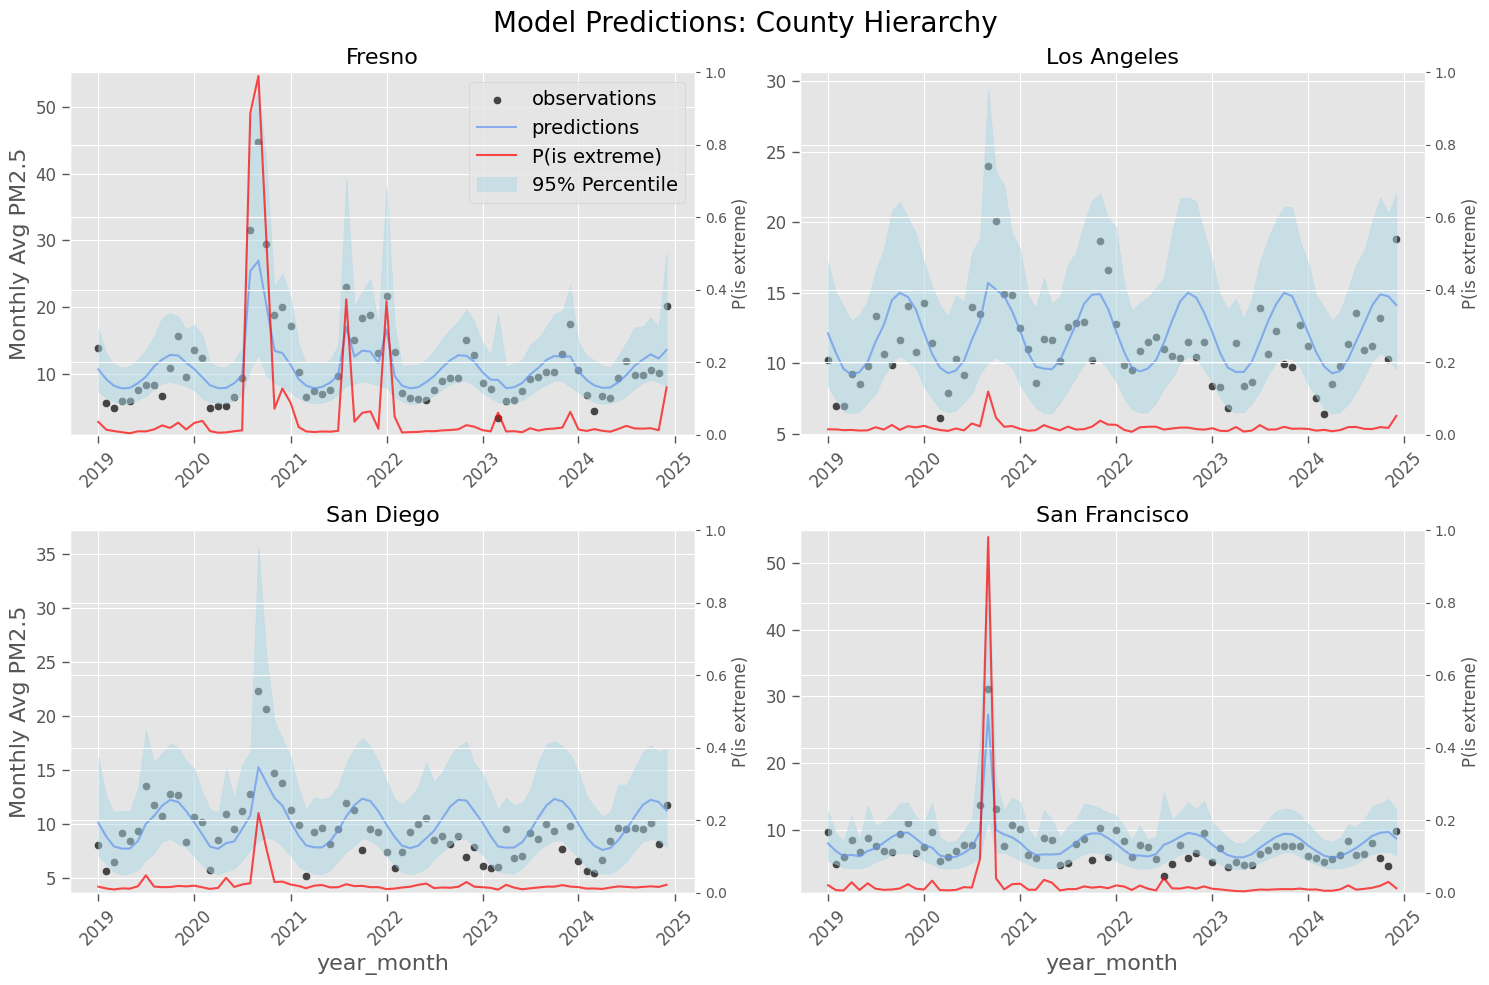

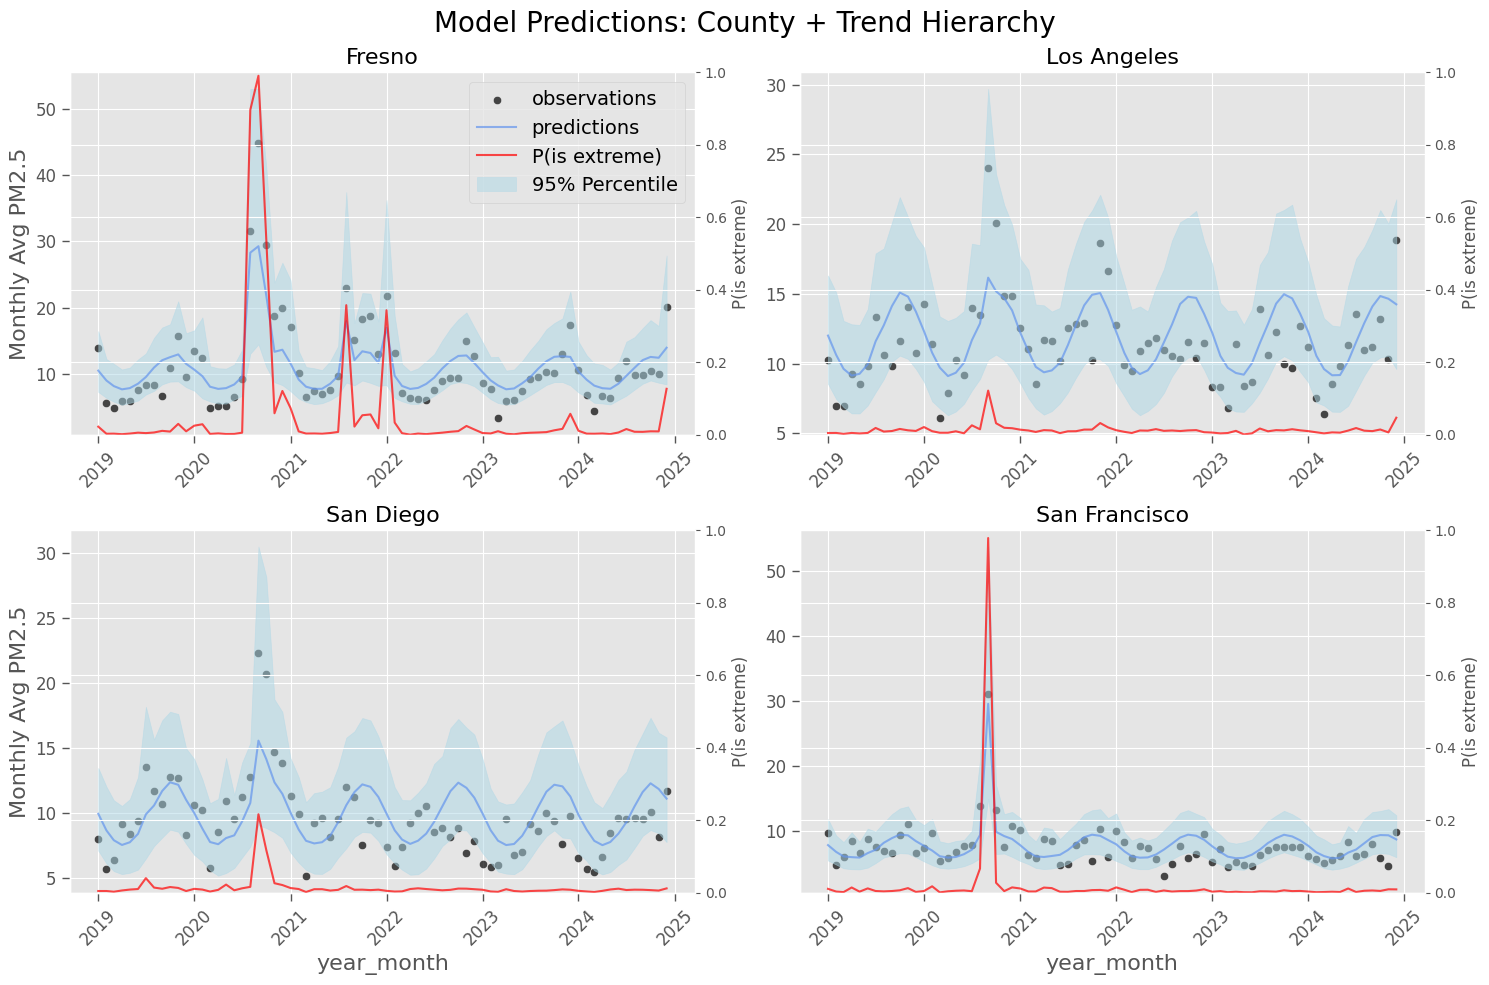

In [55]:
plot_model_predictions(
    data=monthly_avg,
    model_col='predicted_means_no_hierarchy',
    lower_col='lower_bound_no_hierarchy',
    upper_col='upper_bound_no_hierarchy',
    is_extreme_col='is_extreme_mean_no_hierarchy',
    plot_counties=plot_counties,
    title_suffix='No Hierarchy'
)

plot_model_predictions(
    data=monthly_avg,
    model_col='predicted_means_county_hierarchy',
    lower_col='lower_bound_county_hierarchy',
    upper_col='upper_bound_county_hierarchy',
    is_extreme_col='is_extreme_mean_county_hierarchy',
    plot_counties=plot_counties,
    title_suffix='County Hierarchy'
)

plot_model_predictions(
    data=monthly_avg,
    model_col='predicted_means_county_trend_hierarchy',
    lower_col='lower_bound_county_trend_hierarchy',
    upper_col='upper_bound_county_trend_hierarchy',
    is_extreme_col='is_extreme_mean_county_trend_hierarchy',
    plot_counties=plot_counties,
    title_suffix='County + Trend Hierarchy'
)


Observed data (black dots) and predictions (blue lines) are shown for 4 counties. The shaded areas represent the 5%–95% prediction intervals (the uncertainty rang). Both hierarchical models fit the data somewhat better than the model without hierarchy. The `is_extreme` variable highlights unusual observations, though there is still room for improvement (more on this later).

# Model comparison

Let’s compare our three models using `az.compare()`. This shows how well each one generalizes by estimating out-of-sample predictive performance. 

We should pay attention to these metrics:

* **loo (Leave-One-Out cross-validation)**: Lower is better because it means the model predicts new data more accurately.

* **p_loo (Effective number of parameters)**: This tells us about model complexity. Higher values mean the model is more complex.

* **weight**: This gives the relative chance that a model is the best among the ones compared, based on stacking or averaging.

In [56]:
compare_df = az.compare({"model_no_hierarchy": trace_no_hierarchy, 
                         "model_county_hierarchy": trace_county_hierarchy, 
                         "model_county_trend_hierarchy": trace_county_trend_hierarchy}, 
                         ic='loo', 
                         method = 'stacking')
display(compare_df)


/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/predict-demand/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated sh

rank     elpd_loo       p_loo   elpd_diff  \
model_county_trend_hierarchy     0 -8145.559374  341.783228    0.000000   
model_county_hierarchy           1 -8204.761459  399.229412   59.202085   
model_no_hierarchy               2 -8885.374754  305.092721  739.815380   

                                    weight         se        dse  warning  \
model_county_trend_hierarchy  9.995051e-01  64.025234   0.000000     True   
model_county_hierarchy        5.460271e-11  64.095344   4.543782     True   
model_no_hierarchy            4.949323e-04  64.646483  35.575720     True   

                             scale  
model_county_trend_hierarchy   log  
model_county_hierarchy         log  
model_no_hierarchy             log

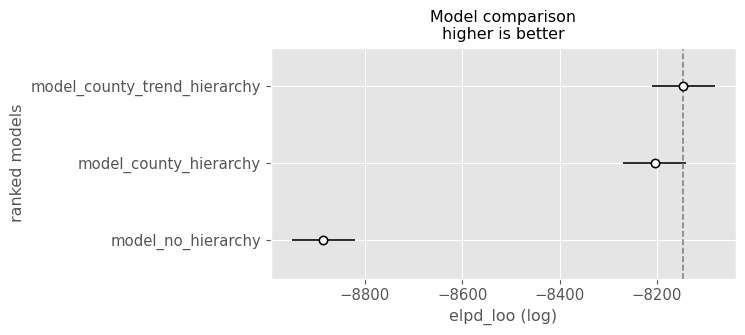

In [57]:
az.plot_compare(compare_df)
plt.show()

We can see that both hierarchical models clearly outperform the one without hierarchy. There’s a slight preference for the model that includes both county and trend hierarchy.

# Conclusion and further steps

This tutorial was an example of building Bayesian hierarchical models in PyMC, model inspection and model comparison. The model picks up on differences between counties and detects extreme events, it could still be improved.

Some ways to improve the model:

1. Add weather data such as average, minimum, and maximum temperature and humidity to better explain PM2.5 variation.

2. Include wildfire data, since PM2.5 spikes are often wildfire-related, though other pollution sources exist.

3. Investigate clusters in the data and consider adding a cluster-level hierarchy. For example, coastal vs. inland California differ in climate and pollution patterns, though urbanization might affect this relationship.

4. Experiment with the trend structure. Currently, each county has its own trend,  but a global trend might be enough.

5. Revisit priors and their parameters. The current choices worked well for the dataset but should be reevaluated as you add more data.

6. Examine issues with the `is_extreme` variable and its detection capabilities.

7. Consider using daily data instead of monthly averages. This would require modeling daily seasonality and accounting for weekday/holiday effects, but would increase model complexity and runtime.

6. Add your own ideas :)

After developing a model using data from 2019 to 2024, it would be good to test its predictive performance on 2025 data (unseen during training). Keep in mind that data availability for 2025 may vary across counties.

Data Sources: 
* https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/county/time-series
* https://catalog.data.gov/dataset?tags=wildfire
* https://projects.capradio.org/california-fire-history/
* https://scholars.georgiasouthern.edu/en/datasets/california-weather-and-fire-prediction-dataset-19842025-with-engi
* https://data.ca.gov/dataset/cal-fire
* https://www.kaggle.com/datasets/vivekattri/california-wildfire-damage-2014-feb2025
* https://zenodo.org/records/14712845

Keep in mind that some of these datasets are on the state or national level, some are on the county-level.


Links to some interesting papers about Bayesian modeling and PM2.5 I found (no need to implement these models, they're just a good starting point for further reading and inspiration):

* https://www.nature.com/articles/s41370-022-00471-4
* https://pmc.ncbi.nlm.nih.gov/articles/PMC8102649/
* https://onlinelibrary.wiley.com/doi/10.1155/2020/7135142
* https://ehp.niehs.nih.gov/doi/10.1289/ehp.6980
* https://doi.org/10.1371/journal.pone.0272774
* https://link.springer.com/article/10.1007/s11869-025-01762-z
* https://www.sciencedirect.com/science/article/pii/S0160412018303891
* https://ajehe.umsha.ac.ir/Article/58031
* https://www.mdpi.com/2073-4433/15/5/594
